In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
from io import StringIO

old_stderr = sys.stderr
sys.stderr = StringIO()

### Preparing Oil Data

In [13]:
PETROL_FILE_PATH = '../../../volza/petroleum/petrol_crude_oil_spot_price.csv'

petrol_df = pd.read_csv(PETROL_FILE_PATH, delimiter=';', on_bad_lines='warn')
petrol_df['Date'] = pd.to_datetime(petrol_df['Date'])

# Split based on types of oil
brent_df = petrol_df[petrol_df['product-name']=='UK Brent Crude Oil']
wti_df = petrol_df[petrol_df['product-name']=='WTI Crude Oil']

brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


### Cleaning up Volza dataset

In [14]:
# Only keep rows where we have usable quantity units (kg, ton) and standardizing it.
def convert_to_kg(df, quantity_col='Std. Quantity', unit_col='Std. Unit', value_col='Value'):
    converstion_factors = {
        'TON': 1000,
        'TNE': 1000,
        'KGS': 1,
        'Kgs': 1,
    }

    df_filtered = df[df[unit_col].isin(converstion_factors.keys())]

    def convert(row):
        unit = row[unit_col]
        quantity = row[quantity_col]
        return quantity * converstion_factors.get(unit,1)
    
    df_filtered = df_filtered[df_filtered['Value'] != 0]
    df_filtered['Std. Quantity (KG)'] = df_filtered.apply(convert, axis=1)
    df_filtered = df_filtered[df_filtered['Std. Quantity (KG)'] != 0]

    df_filtered['Std. Unit Rate ($/KG)'] = df_filtered['Value'] / df_filtered['Std. Quantity (KG)']

    return df_filtered

### Preparing Export / Import Data

In [15]:
# Function to find top 5 exporters of commodity based on sum of 'Value'
def find_top_exporters(df, n=5):
    top_exporters = df.groupby('Country of Origin')['Value'].sum().sort_values(ascending=False).head(n).index.tolist()
    return top_exporters

In [16]:
# Function to find top 10 importers of commodity from an exporter based on sum of 'Value'
def find_top_importers_for_exporters(df, exporters, n=10):
    top_importers_by_exporter = {}
    for exporter in exporters:
        top_importers = df[df['Country of Origin'] == exporter].groupby('Country of Destination')['Value'].sum().sort_values(ascending=False).head(n).index.tolist()
        top_importers_by_exporter[exporter] = top_importers
    return top_importers_by_exporter


### Setting up & Cleaning up the main dataframe

In [17]:
VOLZA_FILE_PATH = '../../../volza/copper/copper.csv'

combined_df = pd.read_csv(VOLZA_FILE_PATH)
combined_df = convert_to_kg(combined_df)
combined_df['Date'] = pd.to_datetime(combined_df['Date'], format='mixed')
combined_df = combined_df.merge(brent_df[['Date', 'Brent Oil Value']], on='Date', how='left')
combined_df = combined_df.merge(wti_df[['Date', 'WTI Oil Value']], on='Date', how='left')
combined_df.sort_values('Date', inplace=True)
combined_df.set_index('Date', inplace=True)

### Splitting data into **Top Exporters** & **Top Importers from said Top Exporters**

In [18]:
top_exporters = find_top_exporters(combined_df, n=5)
top_importers_by_exporter = find_top_importers_for_exporters(combined_df, top_exporters, n=10)
print(top_exporters)
print(top_importers_by_exporter)

['Zambia', 'Pakistan', 'Chile', 'Bulgaria', 'Slovakia']
{'Zambia': ['India', 'Tanzania', 'Belgium', 'Netherlands', 'Germany', 'Brazil', 'Poland'], 'Pakistan': ['China', 'Hong Kong', 'Belgium'], 'Chile': ['China', 'Canada', 'South Korea', 'Germany', 'Spain', 'Belgium', 'Japan', 'Brazil', 'Netherlands', 'United States'], 'Bulgaria': ['Belgium', 'Germany', 'Italy', 'Portugal', 'Netherlands', 'Malaysia', 'Latvia', 'Egypt'], 'Slovakia': ['Austria', 'Sweden', 'Italy', 'Romania', 'Czech Republic', 'Belgium', 'Netherlands', 'Hungary']}


### **Analysis**

#### **1. Time Series**
##### **1.1 Crude Oils**

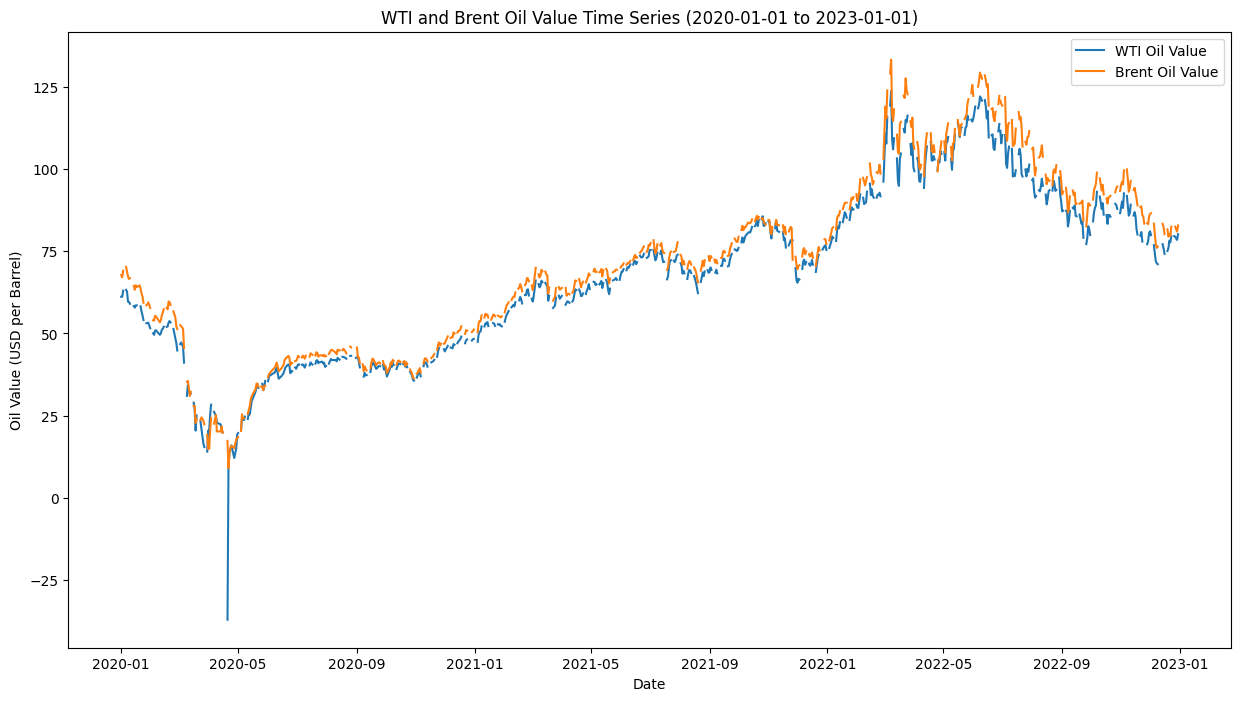

In [19]:
# Setting start & end date to match that of Volza's
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2023-01-01')

filtered_df = combined_df[(combined_df.index >= start_date) & (combined_df.index <= end_date)]

# Plotting the time series for 'WTI Oil Value' and 'Brent Oil Value'
plt.figure(figsize=(15, 8))
plt.plot(filtered_df.index, filtered_df['WTI Oil Value'], label='WTI Oil Value')
plt.plot(filtered_df.index, filtered_df['Brent Oil Value'], label='Brent Oil Value')
plt.title('WTI and Brent Oil Value Time Series (2020-01-01 to 2023-01-01)')
plt.xlabel('Date')
plt.ylabel('Oil Value (USD per Barrel)')
plt.legend()
plt.show()


#### **1.2 Global Commodity Shipment Trend**

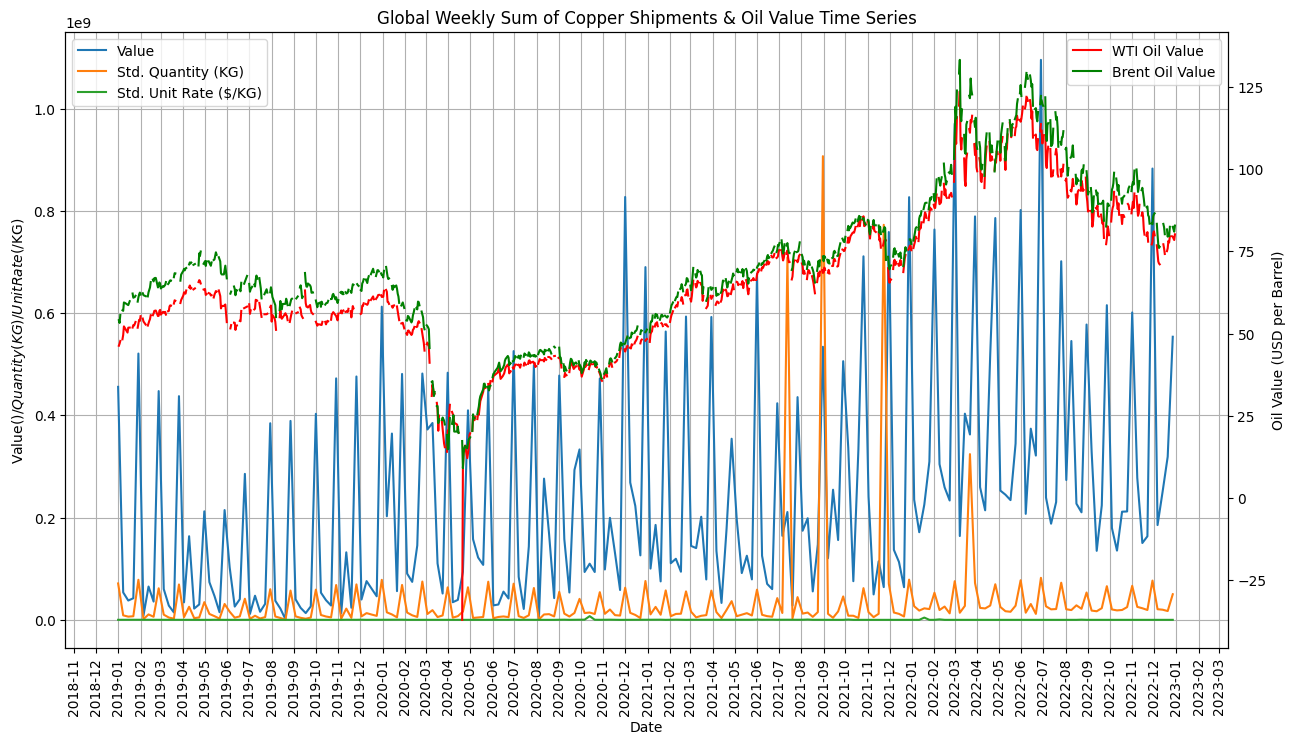

In [25]:

TIME_METRIC = '7D'
NUMERIC_COLUMN = ['Value', 'Std. Quantity (KG)', 'Std. Unit Rate ($/KG)']

# Resample and sum the data globally
weekly_global_data = combined_df[NUMERIC_COLUMN].resample(TIME_METRIC).sum()

fig, ax1 = plt.subplots(figsize=(15, 8))

for column in NUMERIC_COLUMN:
    ax1.plot(weekly_global_data.index, weekly_global_data[column], label=column)

ax1.set_title('Global Weekly Sum of Copper Shipments & Oil Value Time Series')
ax1.set_xlabel('Date')
ax1.set_ylabel('Value($) / Quantity(KG) / Unit Rate ($/KG)')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Filtering the oil data
start_date = '2019-01-01'
end_date = '2023-01-01'
filtered_df = combined_df[(combined_df.index >= pd.to_datetime(start_date)) & (combined_df.index <= pd.to_datetime(end_date))]

# Create a second y-axis for the oil data
ax2 = ax1.twinx()
ax2.plot(filtered_df.index, filtered_df['WTI Oil Value'], label='WTI Oil Value', color='red')
ax2.plot(filtered_df.index, filtered_df['Brent Oil Value'], label='Brent Oil Value', color='green')
ax2.set_ylabel('Oil Value (USD per Barrel)')
ax2.legend(loc='upper right')

ax1.tick_params(axis='x', rotation=90)
plt.show()


##### **1.3 [Top 5 Exporters] to their [Top 10 Importers]**

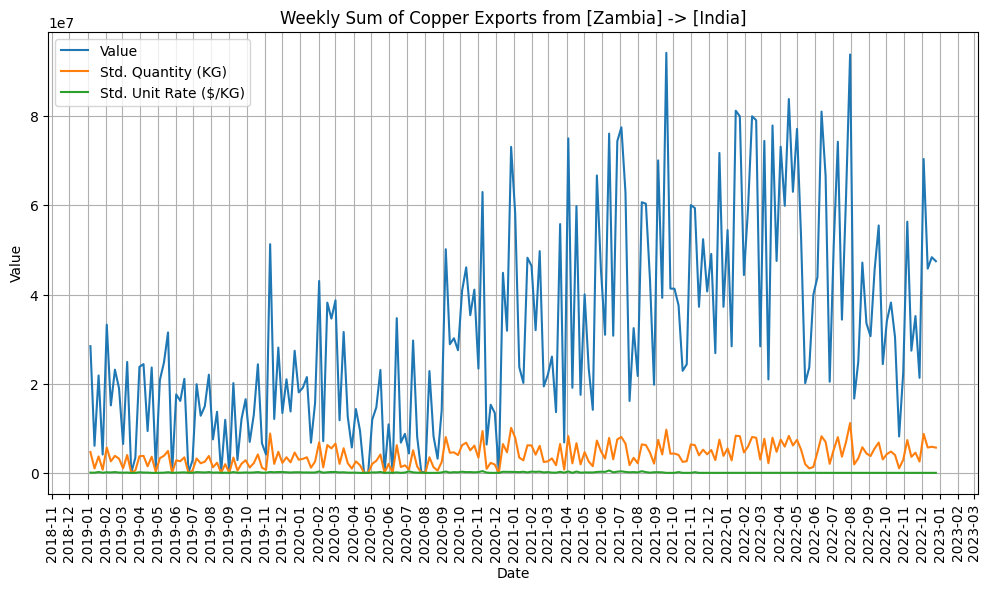

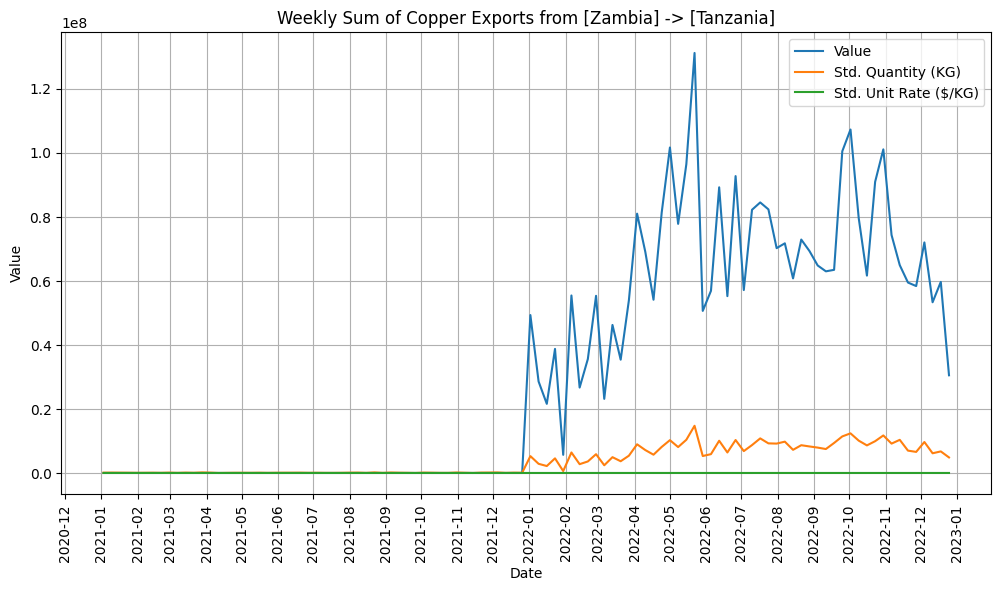

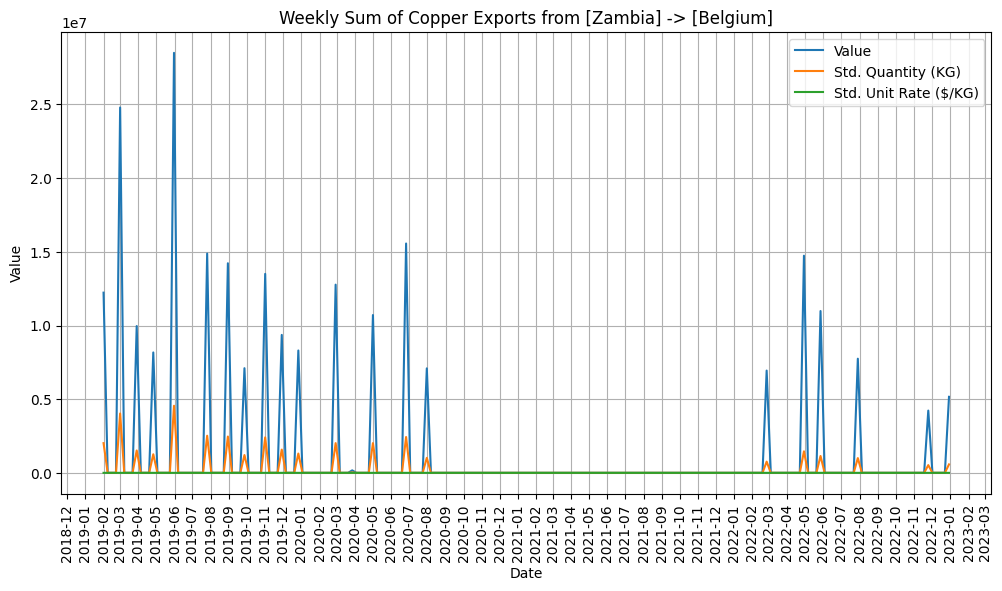

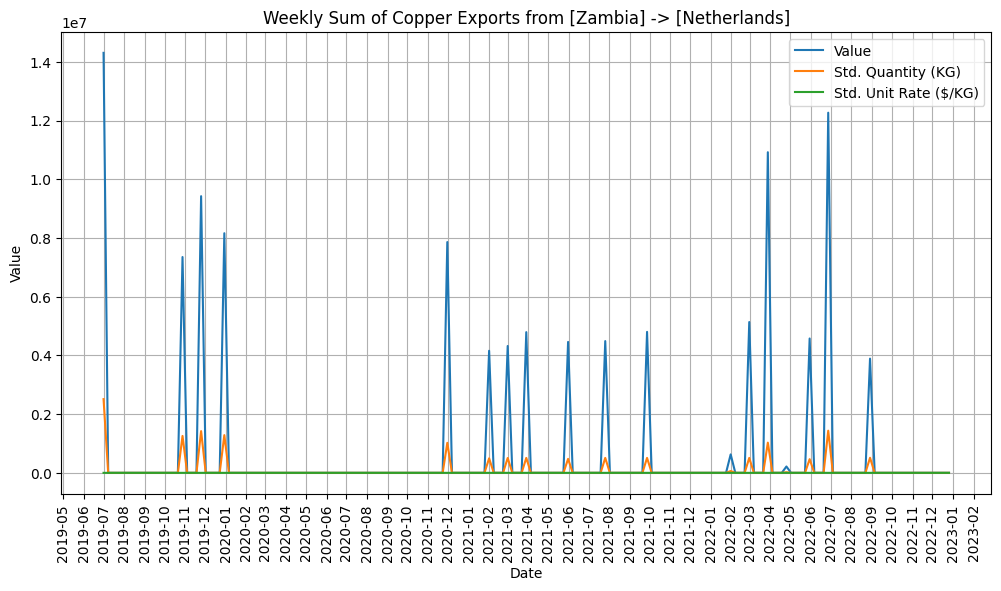

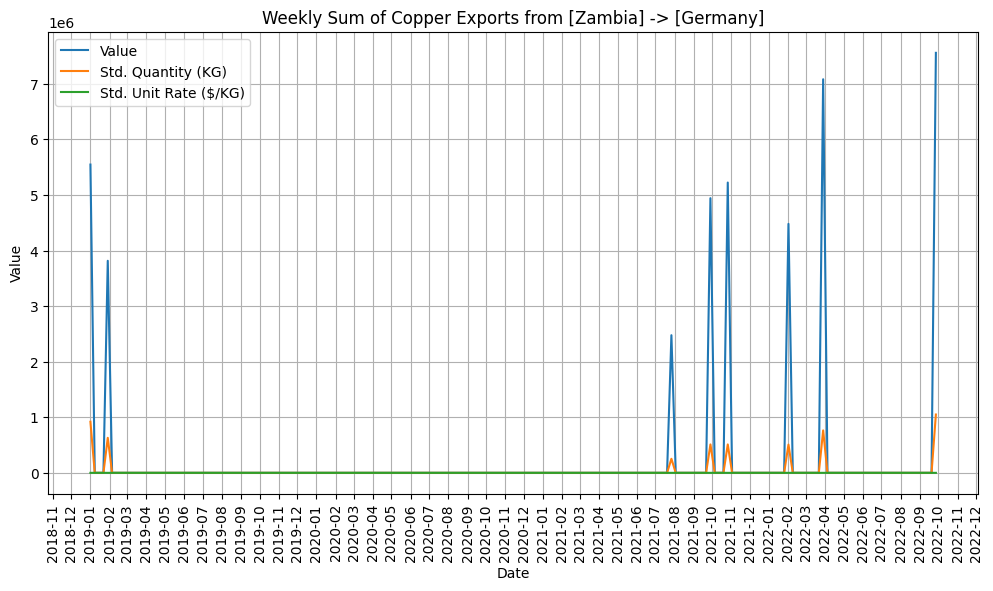

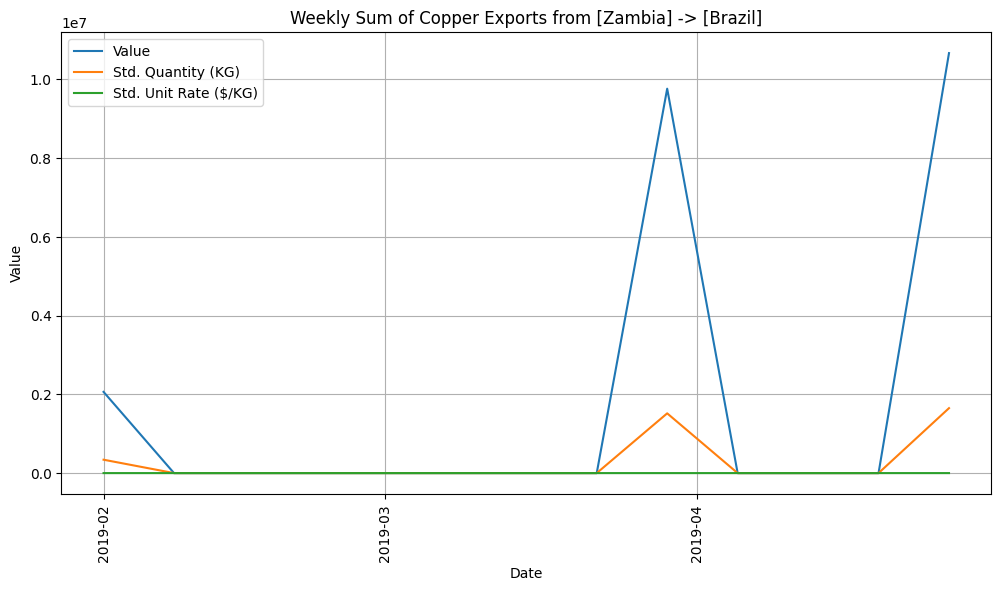

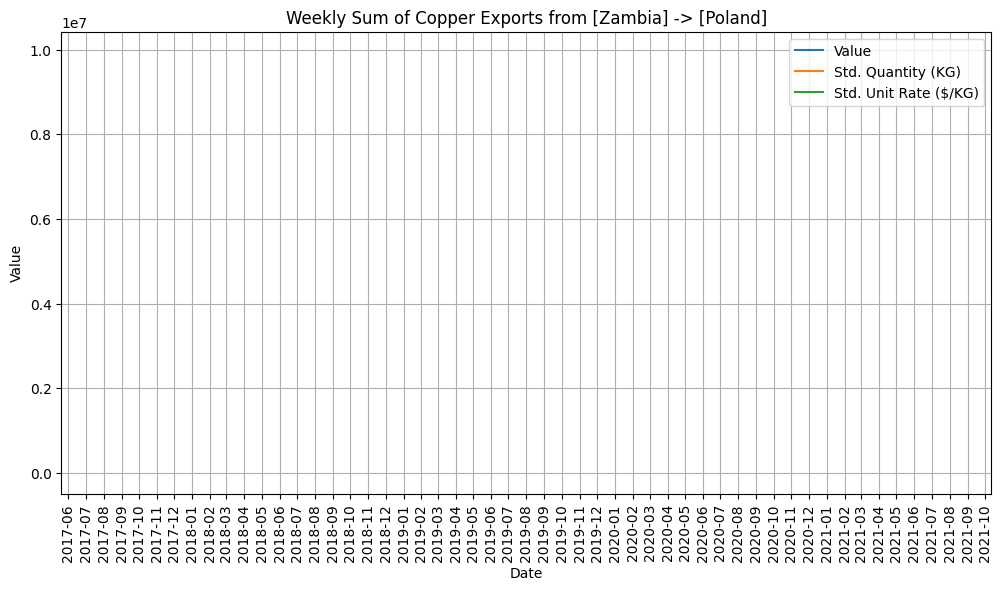

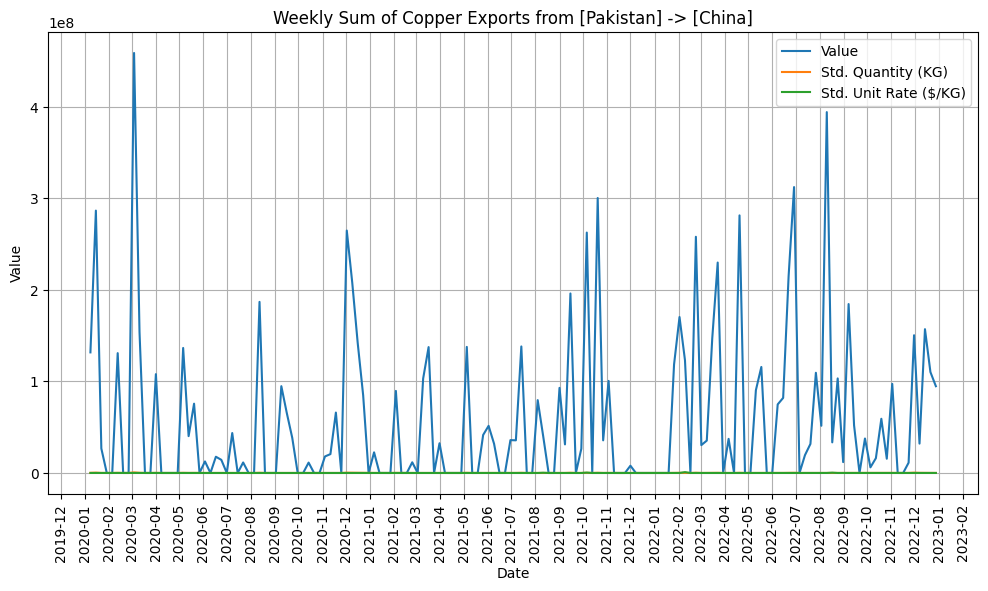

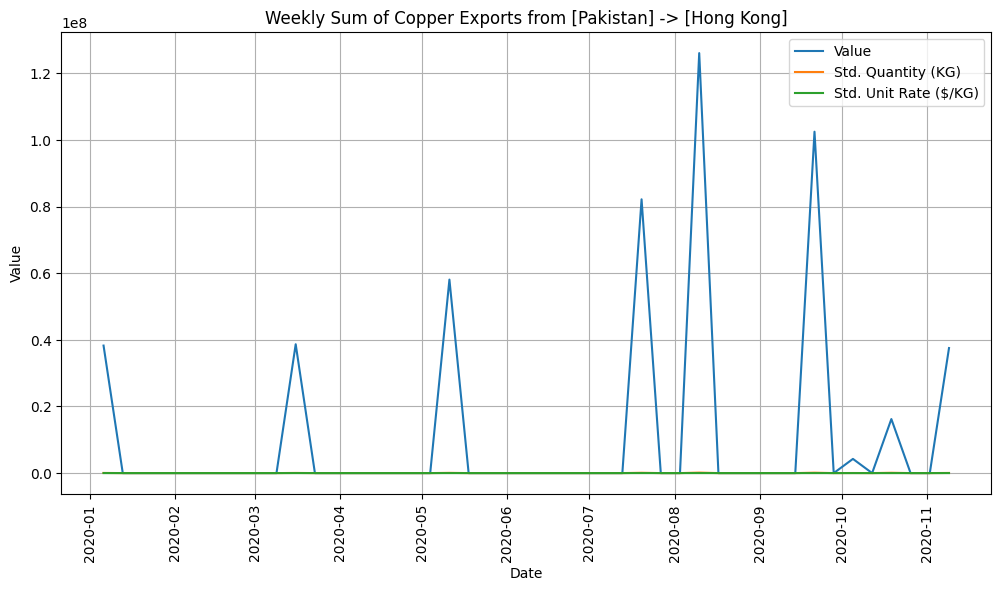

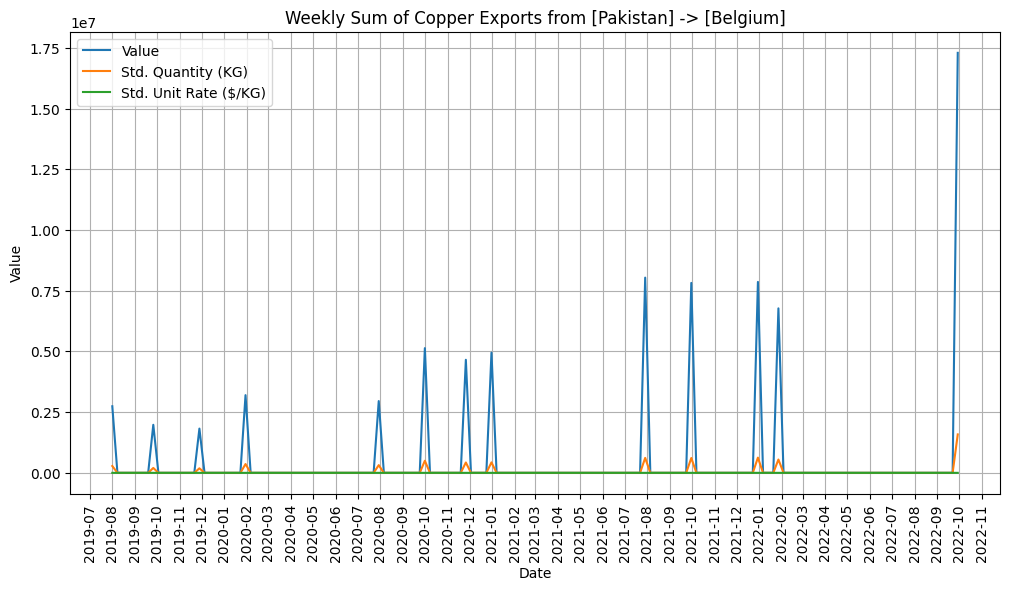

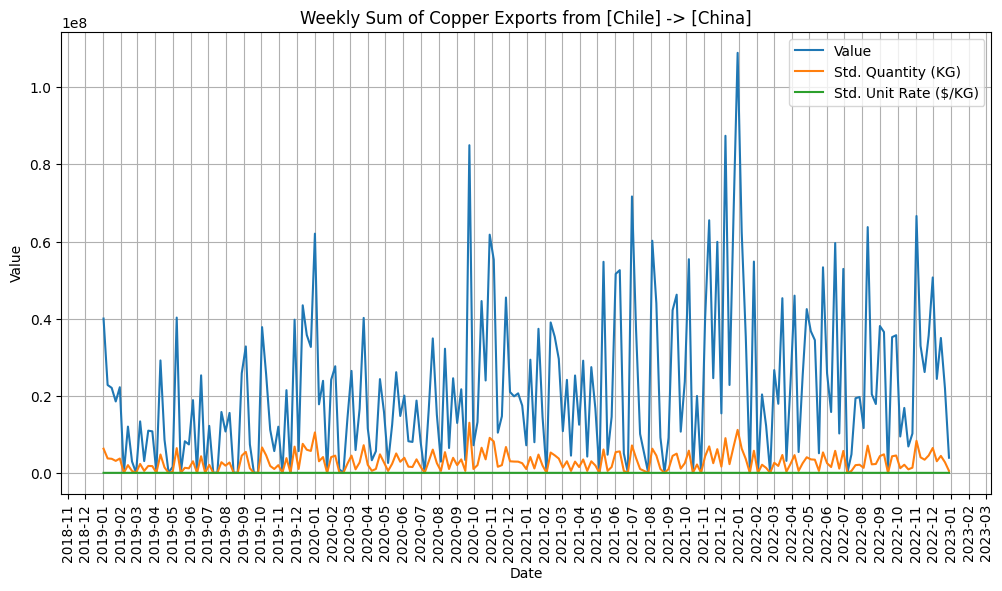

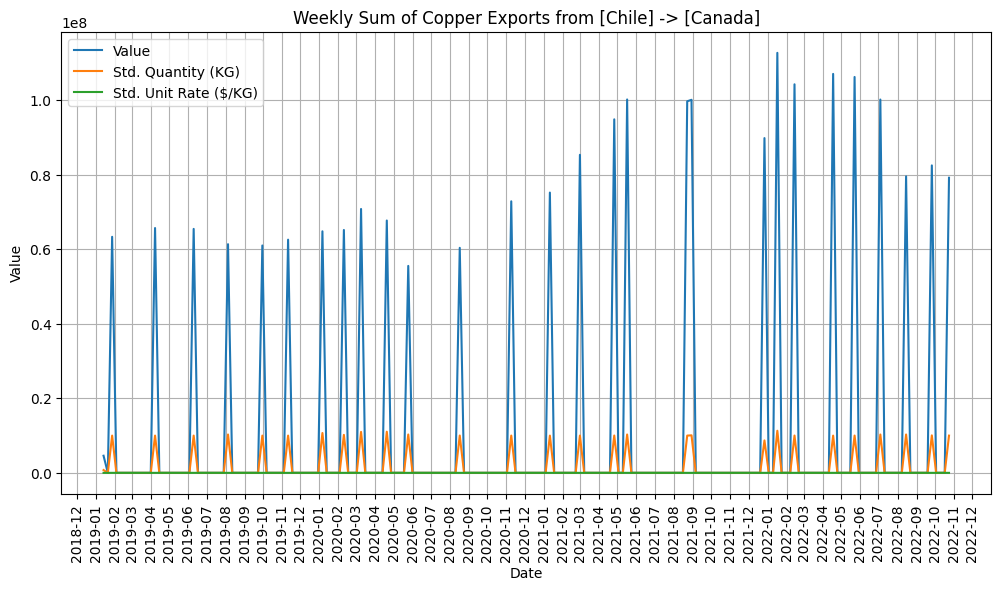

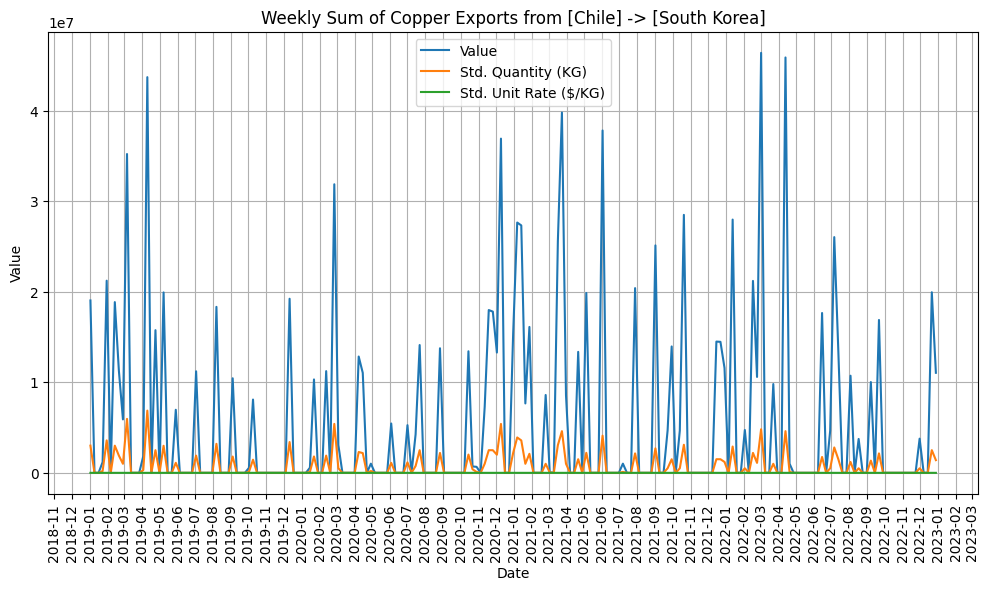

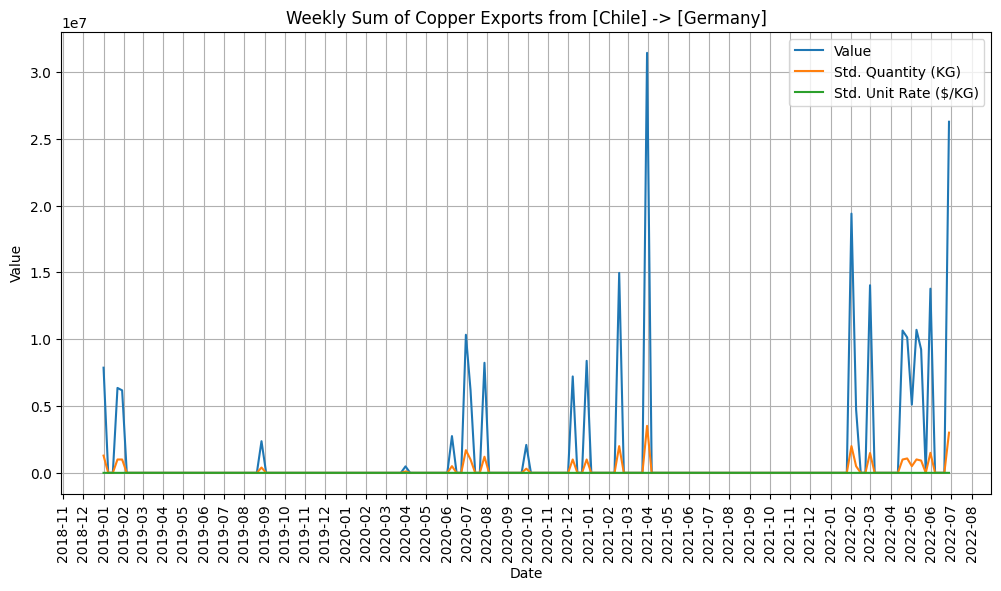

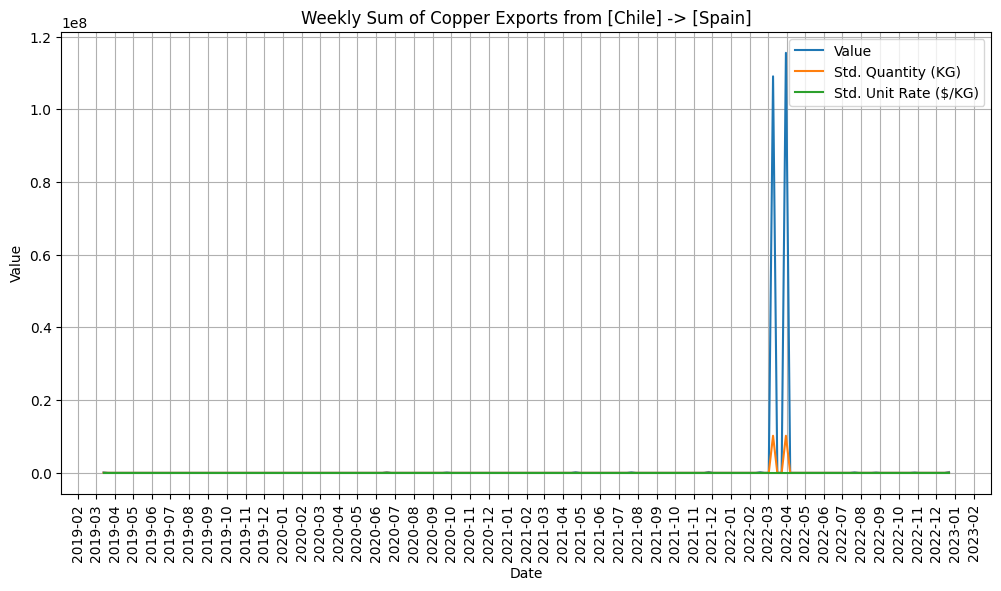

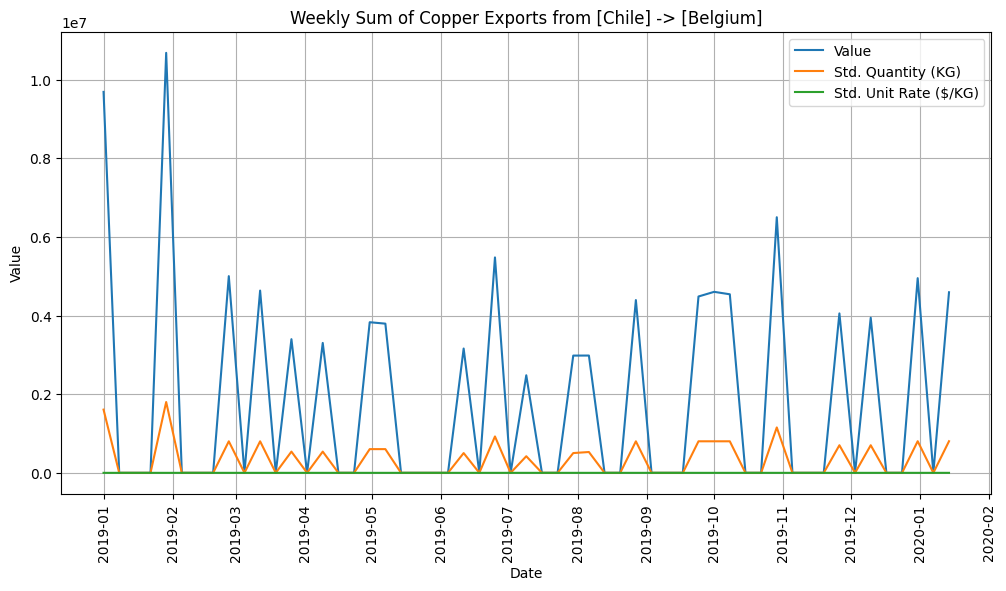

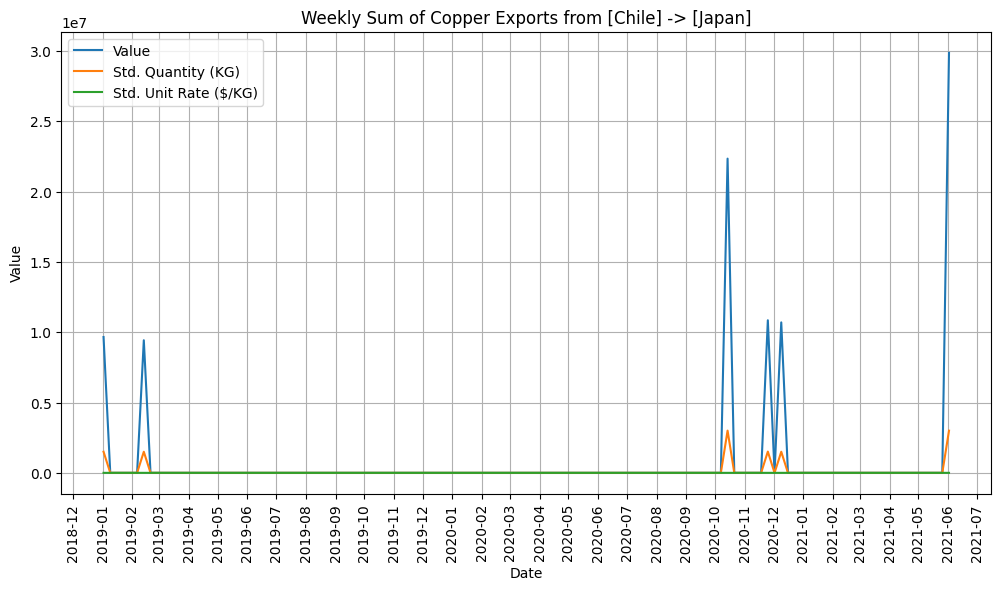

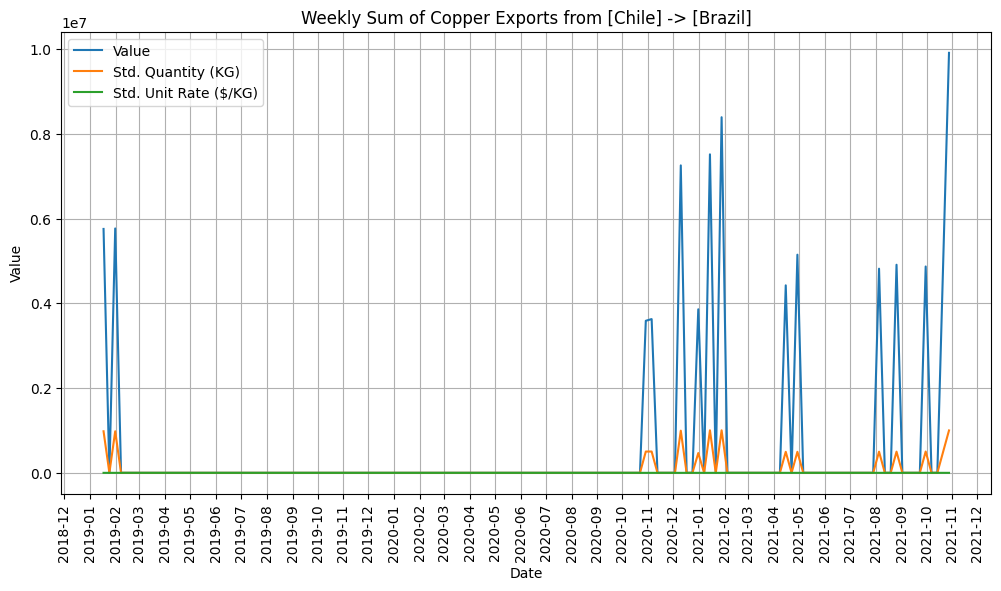

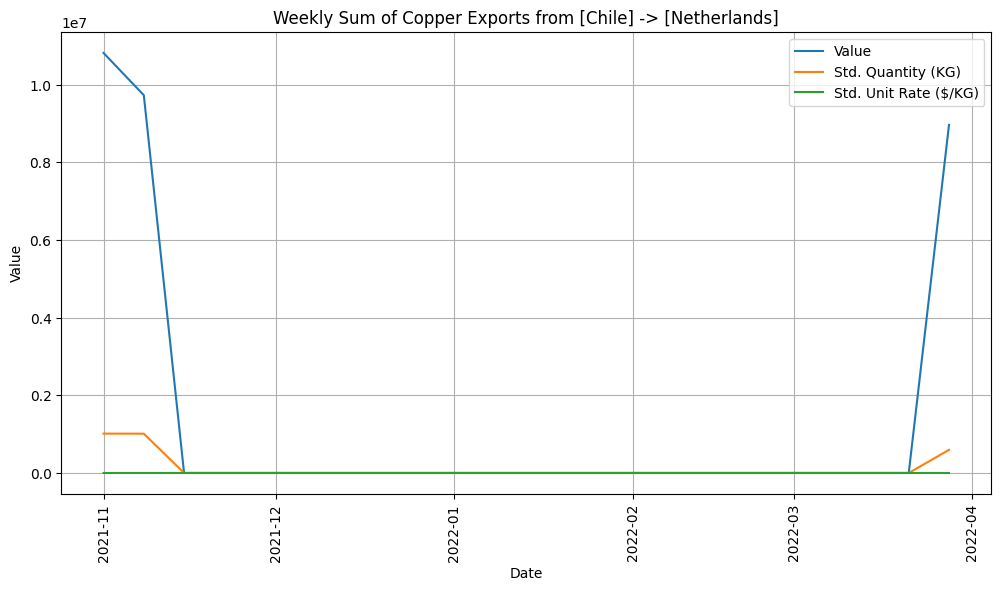

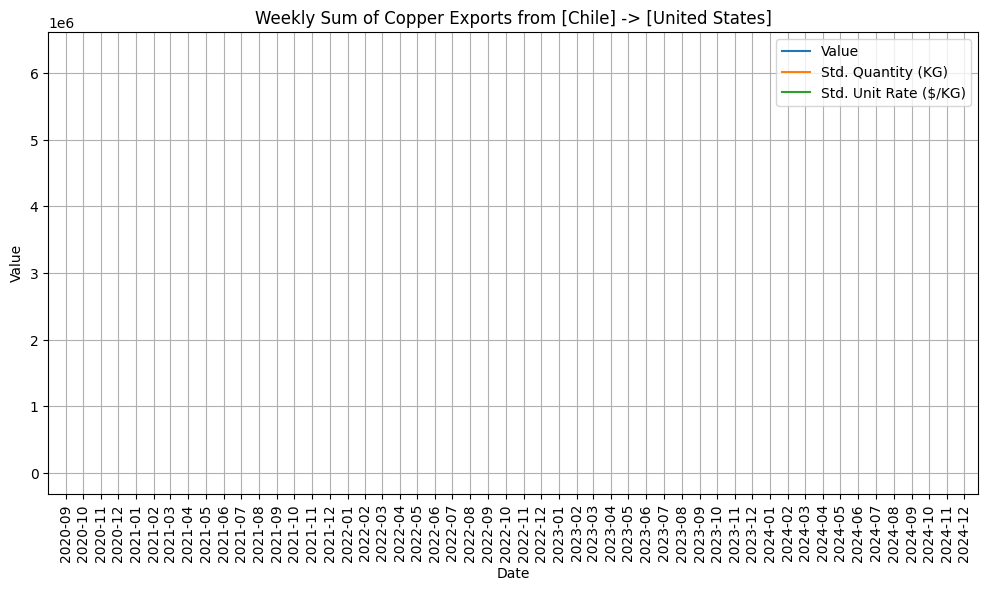

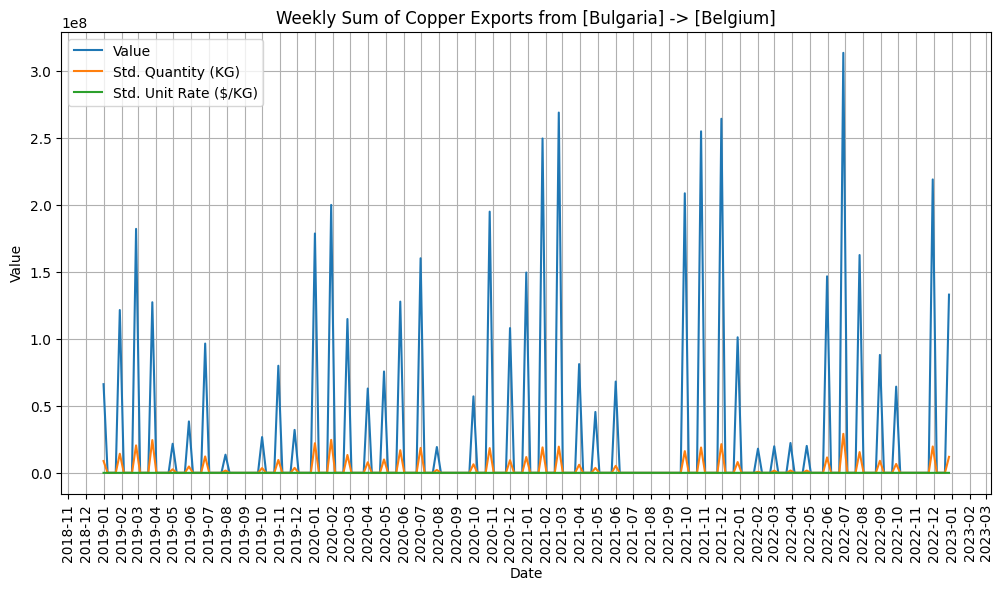

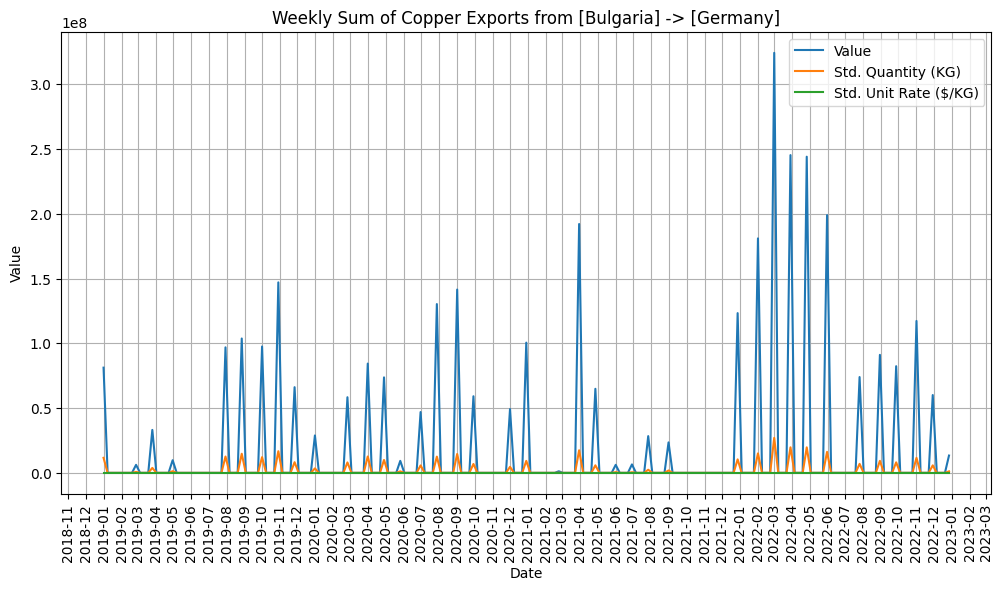

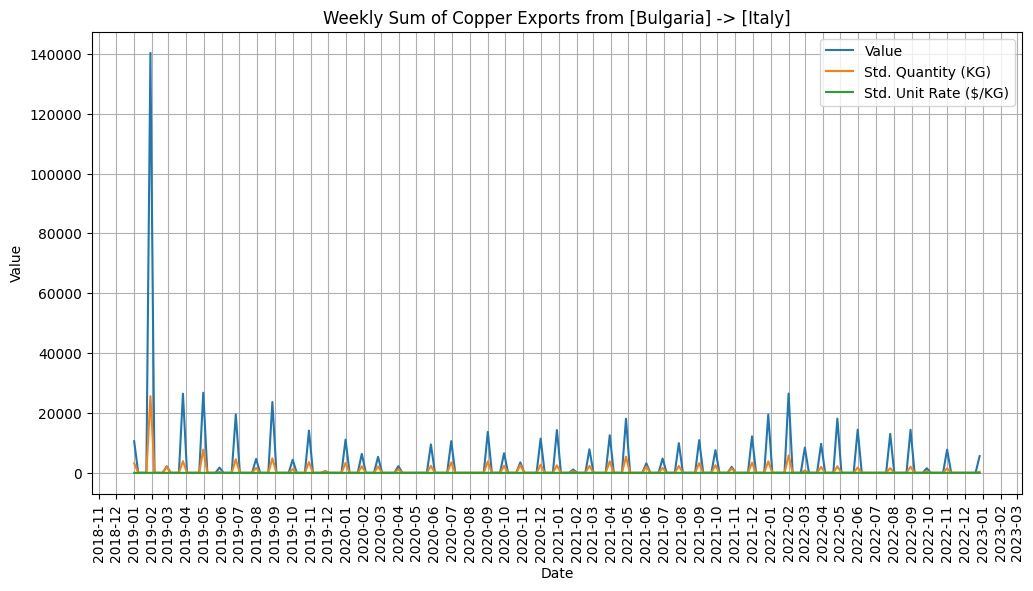

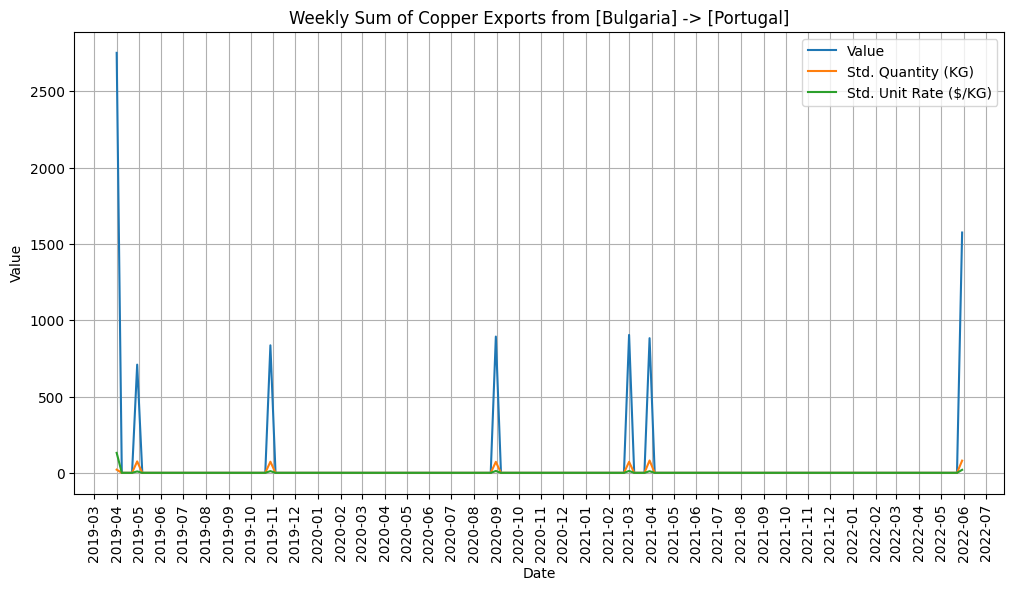

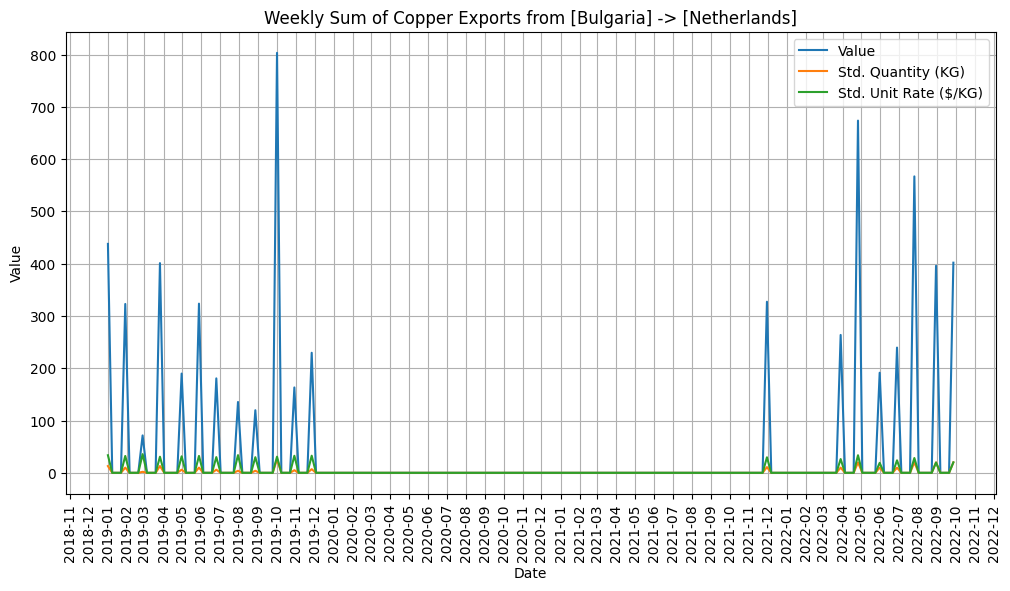

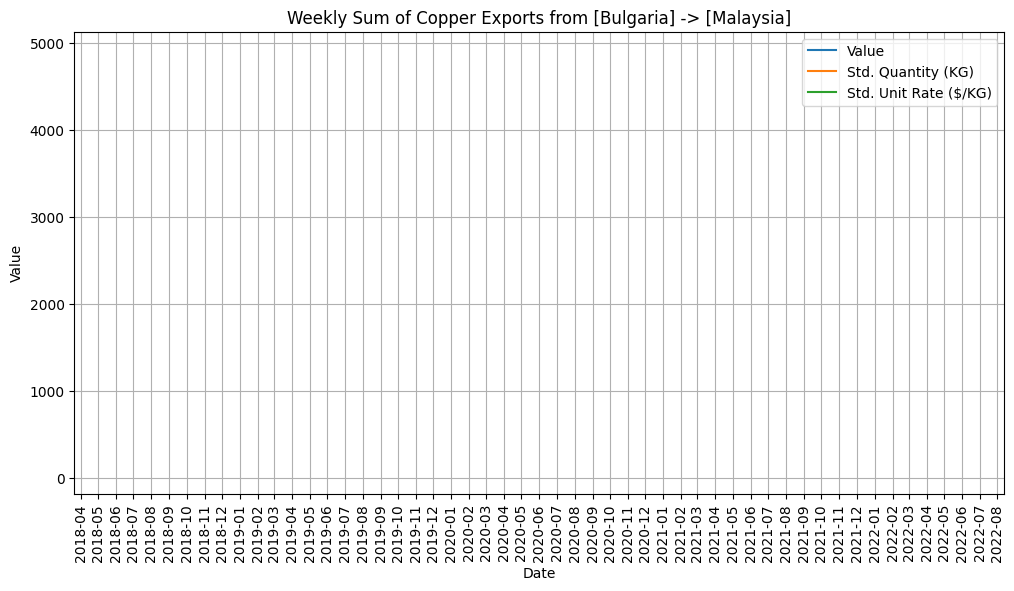

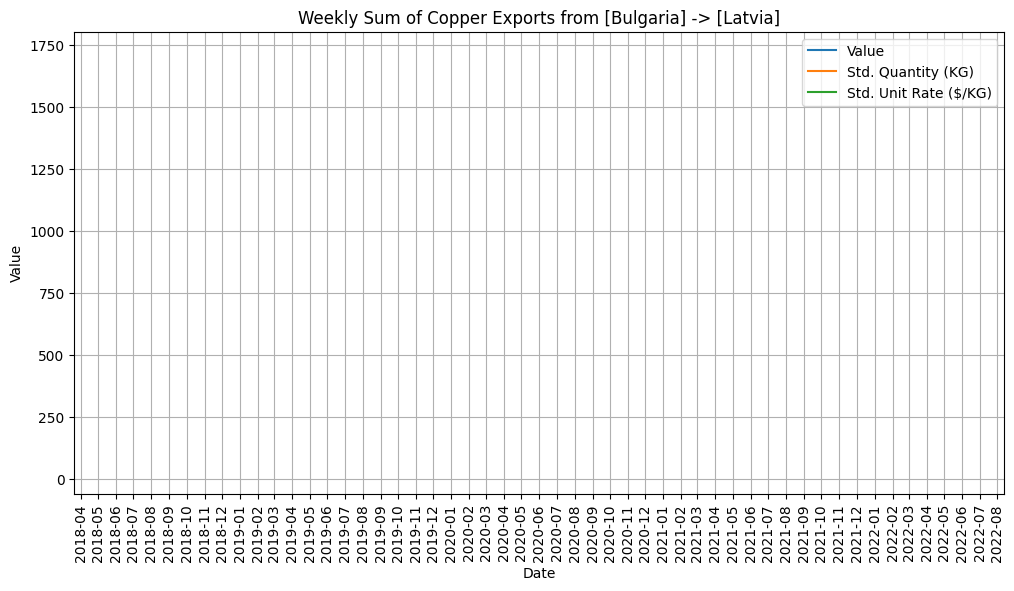

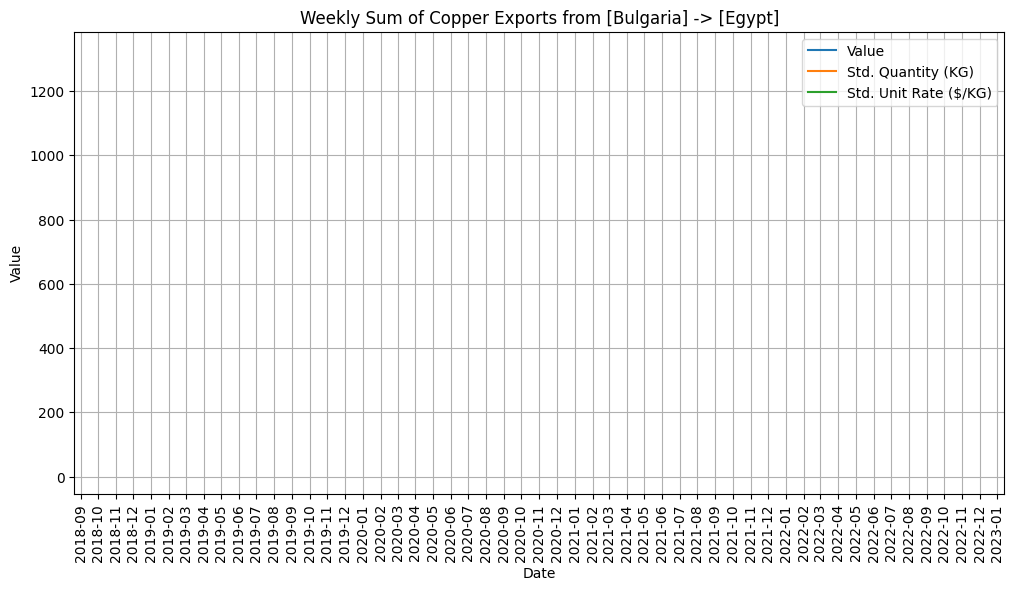

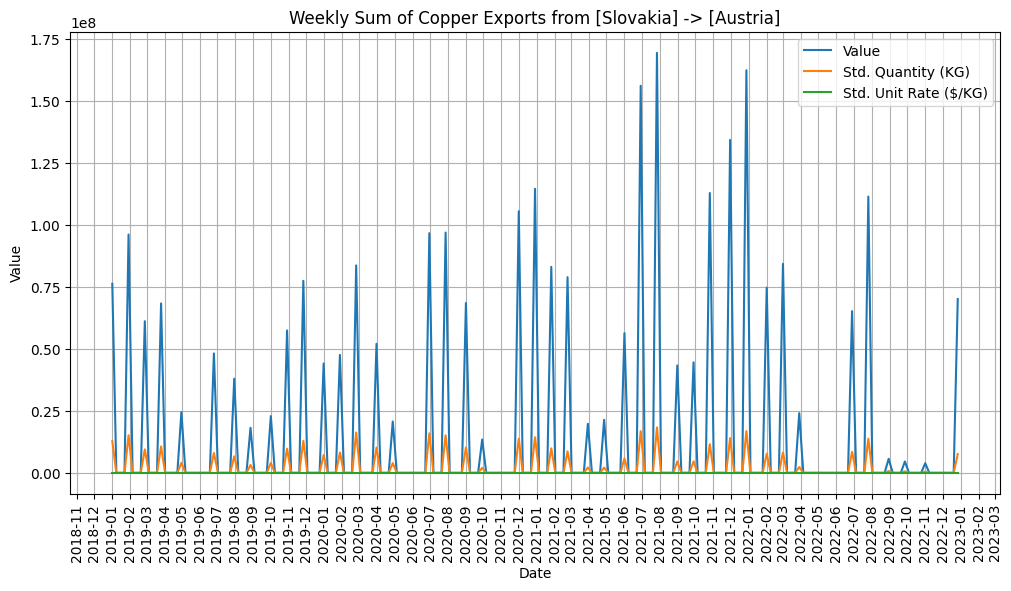

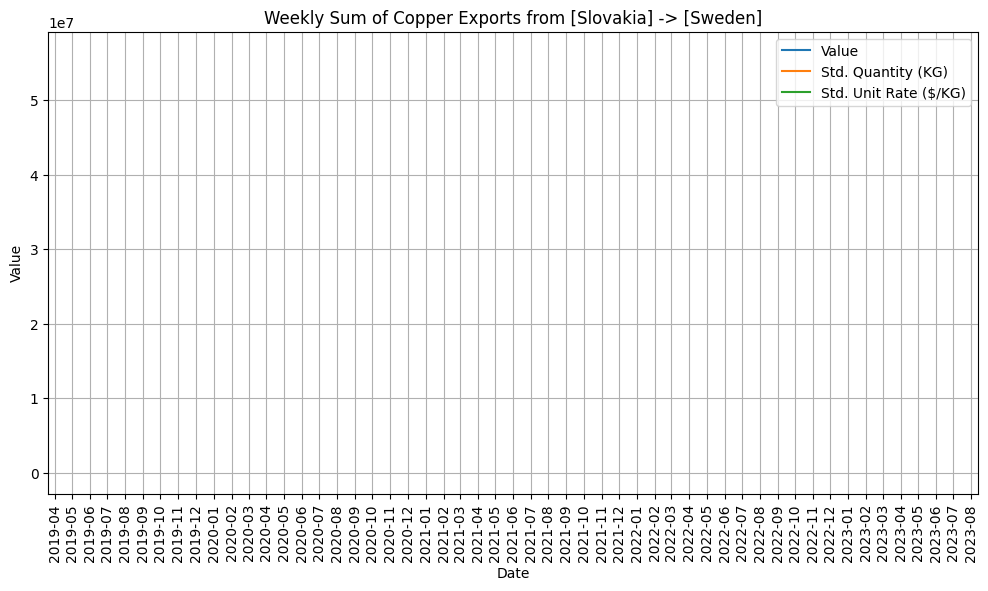

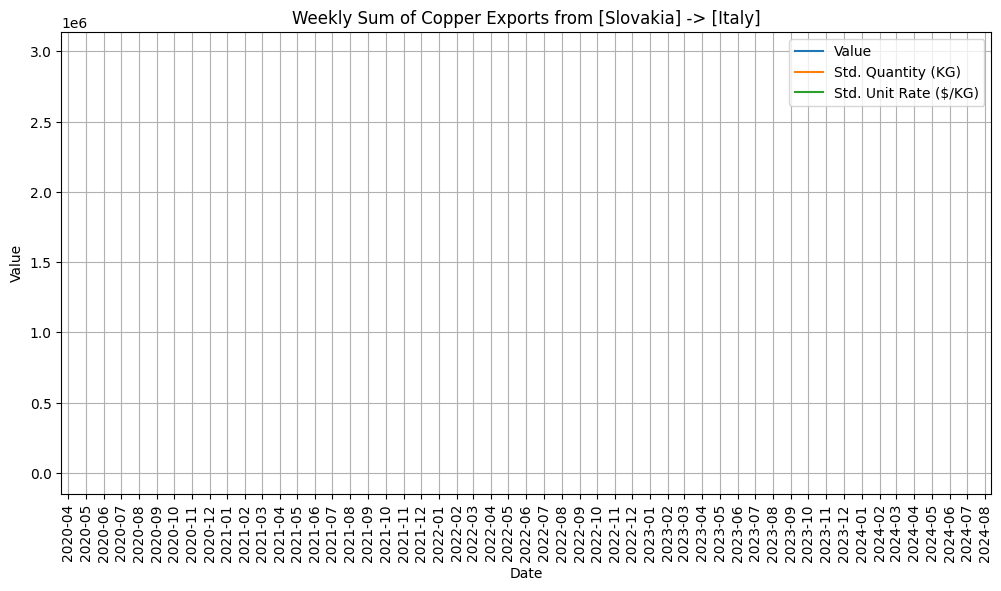

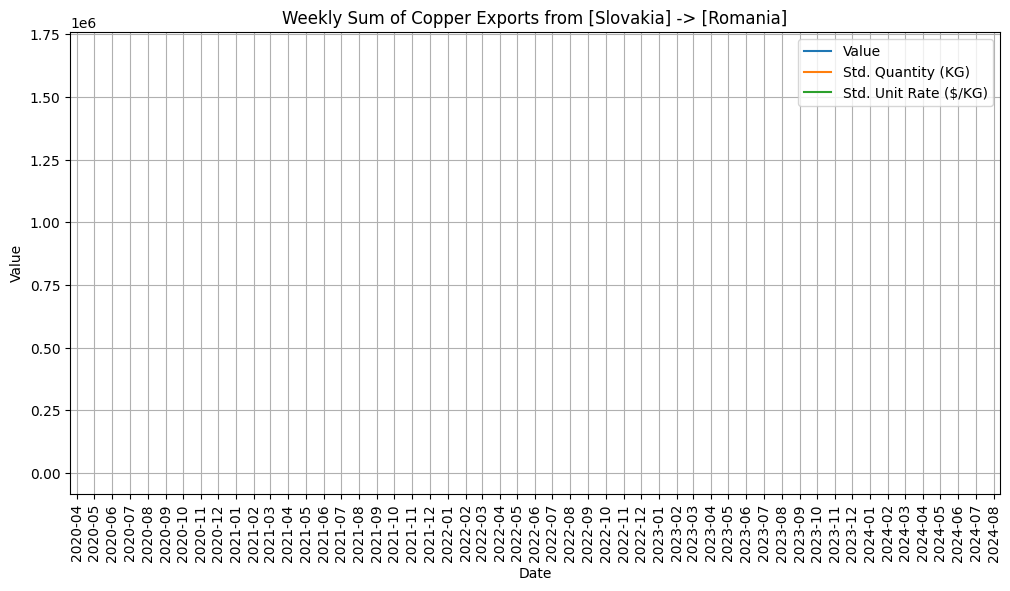

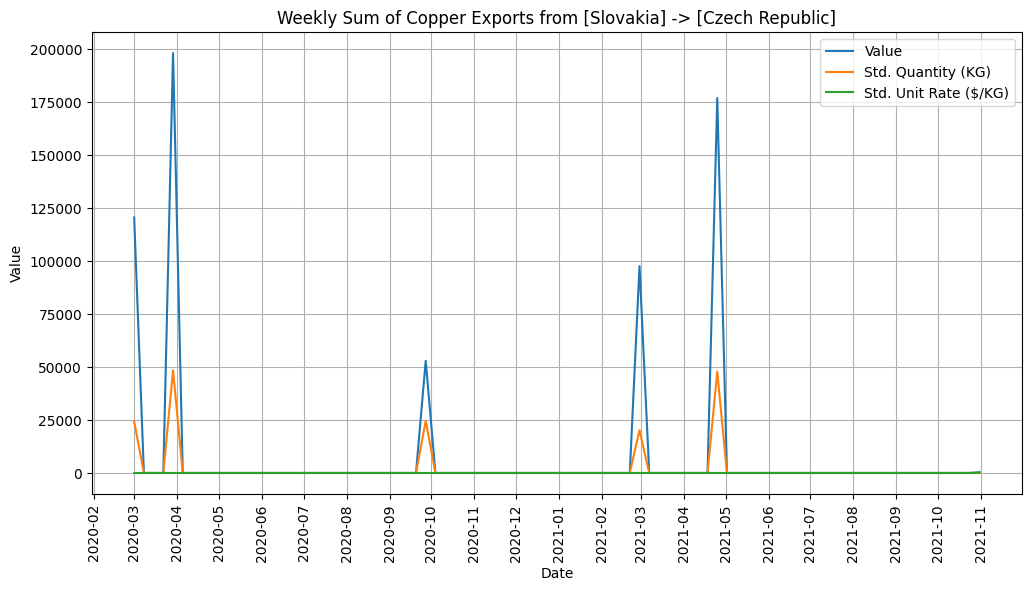

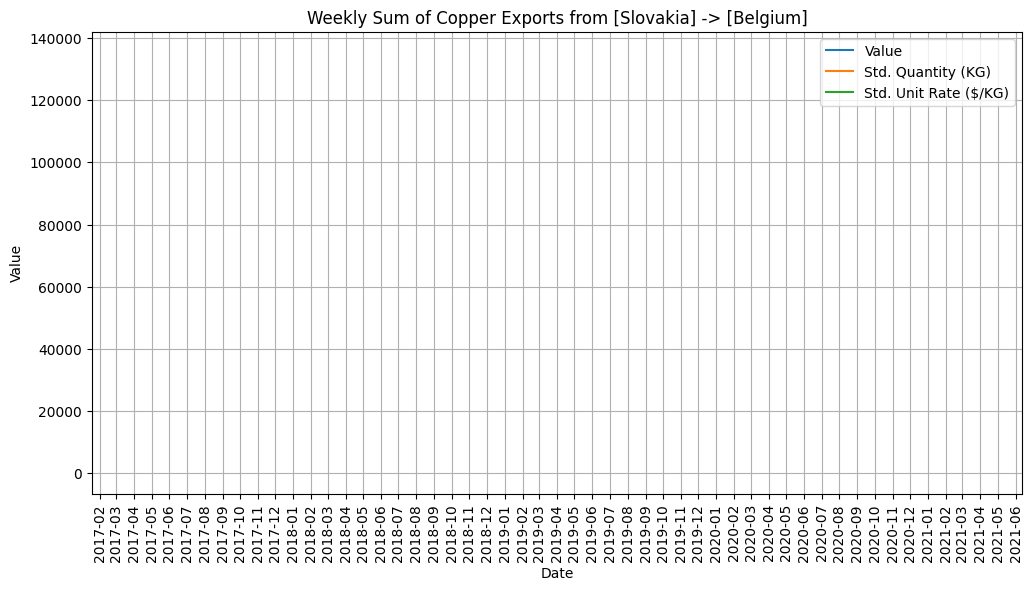

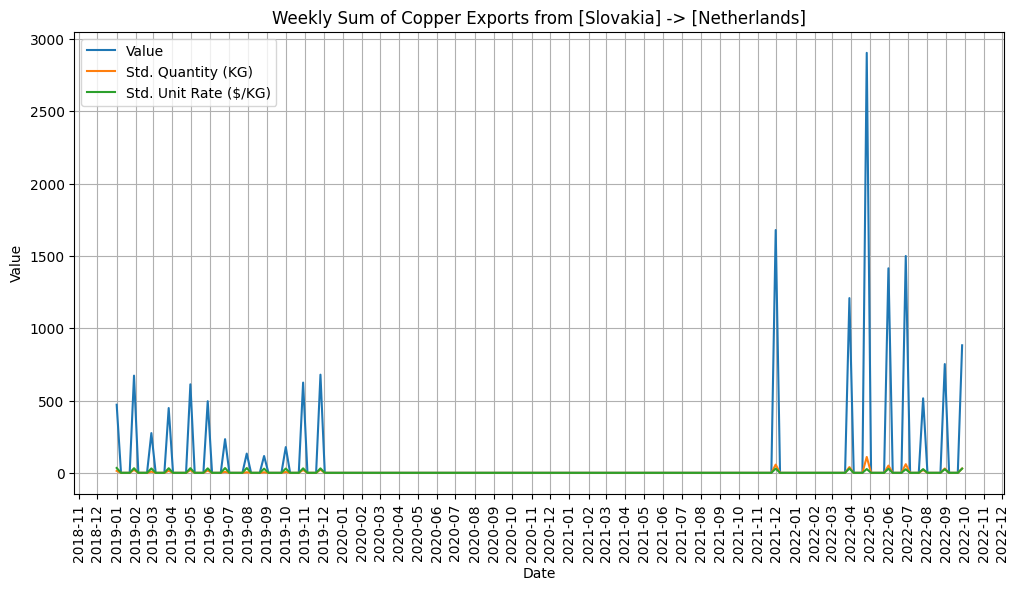

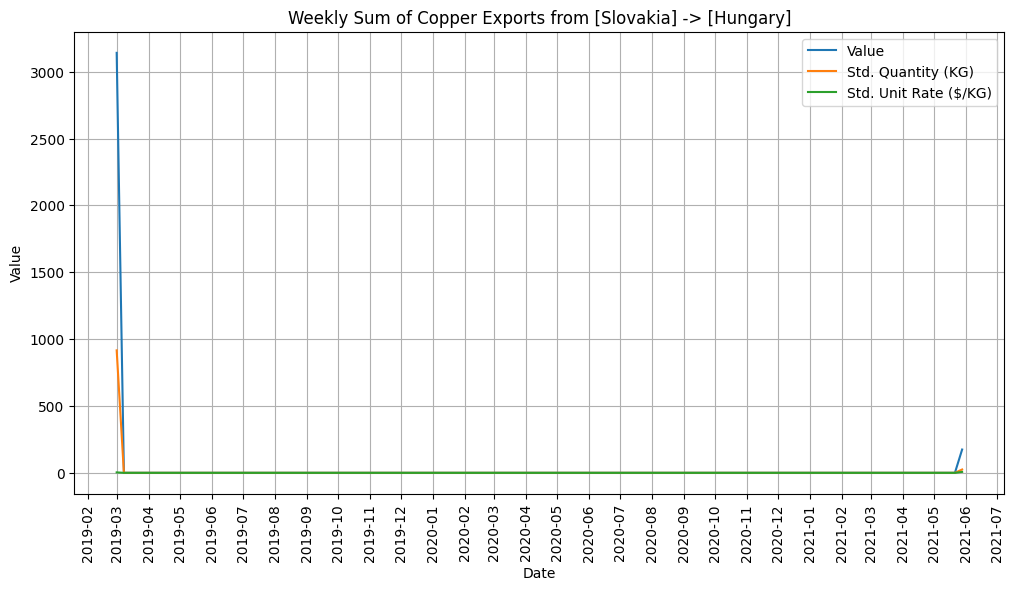

In [21]:
# Plotting
NUMERIC_COLUMN = ['Value', 'Std. Quantity (KG)', 'Std. Unit Rate ($/KG)']
TIME_METRIC = '7D'

for exporter, importers in top_importers_by_exporter.items():
    for importer in importers:
        export_import_data = combined_df[(combined_df['Country of Origin'] == exporter) & (combined_df['Country of Destination'] == importer)]

        # Resample and sum
        weekly_data = export_import_data[NUMERIC_COLUMN].resample(TIME_METRIC).sum()

        # Plotting
        plt.figure(figsize=(12, 6))
        for column in NUMERIC_COLUMN:
            plt.plot(weekly_data.index, weekly_data[column], label=column)

        plt.title(f'Weekly Sum of Copper Exports from [{exporter}] -> [{importer}]')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=90)
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.show()


#### **2. Correlation**
##### **2.1 Times Series Overlay**

In [22]:
plt.figure(figsize=(12, 6))

# Plotting for Exporters
for country, group in export_group:
    weekly_data = group['Value'].resample('7D').sum()
    plt.plot(weekly_data.index, weekly_data, label=f'Export Value for {country}')

# Plotting for Importers
for country, group in import_group:
    weekly_data = group['Value'].resample('7D').sum()
    plt.plot(weekly_data.index, weekly_data, label=f'Import Value for {country}')

plt.title(f'Weekly Sum of Magnesium Exports and Imports')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()


NameError: name 'export_group' is not defined

<Figure size 1200x600 with 0 Axes>

##### **2.2 Spearman & Pearson Correlation**

Pearson Correlation Coefficient: 0.9990478174312865
Spearman Correlation Coefficient: 0.9958815958815961


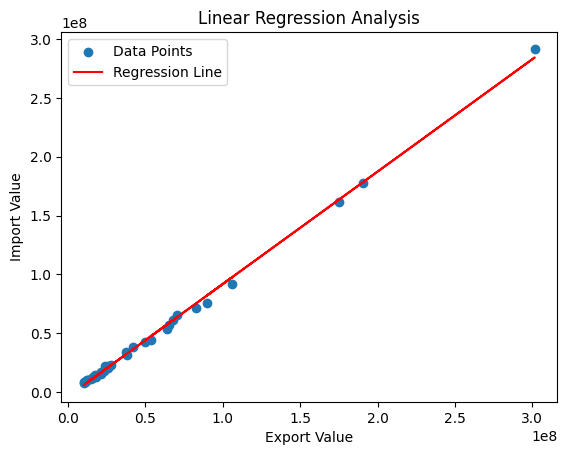

In [ ]:
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

TIME_METRIC = 'M'

weekly_export = export_combined_df['Value'].resample(TIME_METRIC).sum()
weekly_import = import_combined_df['Value'].resample(TIME_METRIC).sum()

# Merge the two dataframes on the date index
combined_weekly = pd.DataFrame({'Export_Value': weekly_export, 'Import_Value': weekly_import})
combined_weekly.dropna(inplace=True)  

# Correlation Analysis
pearson_corr, _ = pearsonr(combined_weekly['Export_Value'], combined_weekly['Import_Value'])
spearman_corr, _ = spearmanr(combined_weekly['Export_Value'], combined_weekly['Import_Value'])
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman Correlation Coefficient: {spearman_corr}")

# Regression Analysis
X = combined_weekly['Export_Value']
y = combined_weekly['Import_Value']
X = sm.add_constant(X)  # Add a constant term to the predictor
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the statistics
# print(model.summary())

# Plotting the linear regression
plt.scatter(combined_weekly['Export_Value'], combined_weekly['Import_Value'], label='Data Points')
plt.plot(combined_weekly['Export_Value'], predictions, color='red', label='Regression Line')
plt.xlabel('Export Value')
plt.ylabel('Import Value')
plt.title('Linear Regression Analysis')
plt.legend()
plt.show()


Exporter: China, Importer: Netherlands
Pearson Correlation Coefficient: 0.9026602780034887
Spearman Correlation Coefficient: 0.9967392753675891


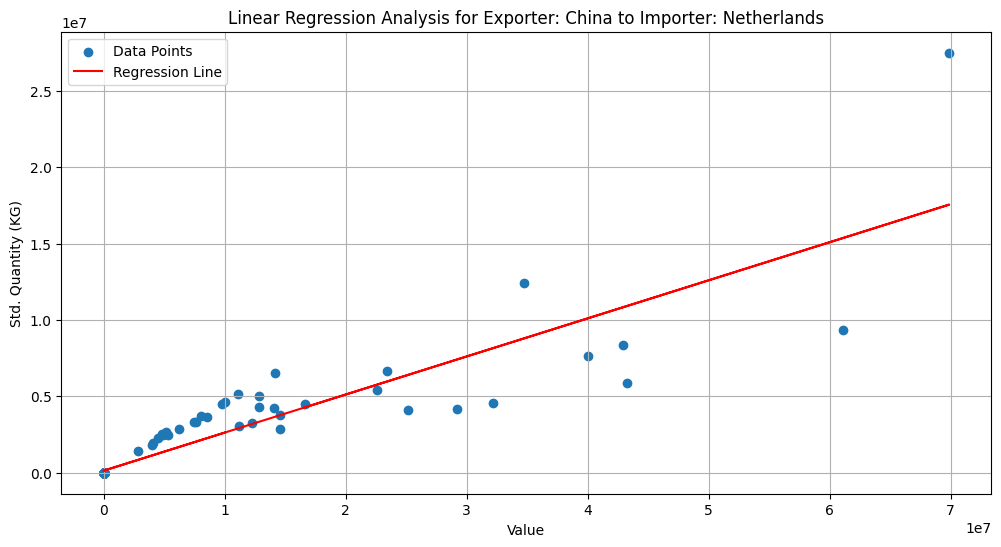

Exporter: China, Importer: Cameroon
Pearson Correlation Coefficient: 0.9866312615765092
Spearman Correlation Coefficient: 0.9990825688073397


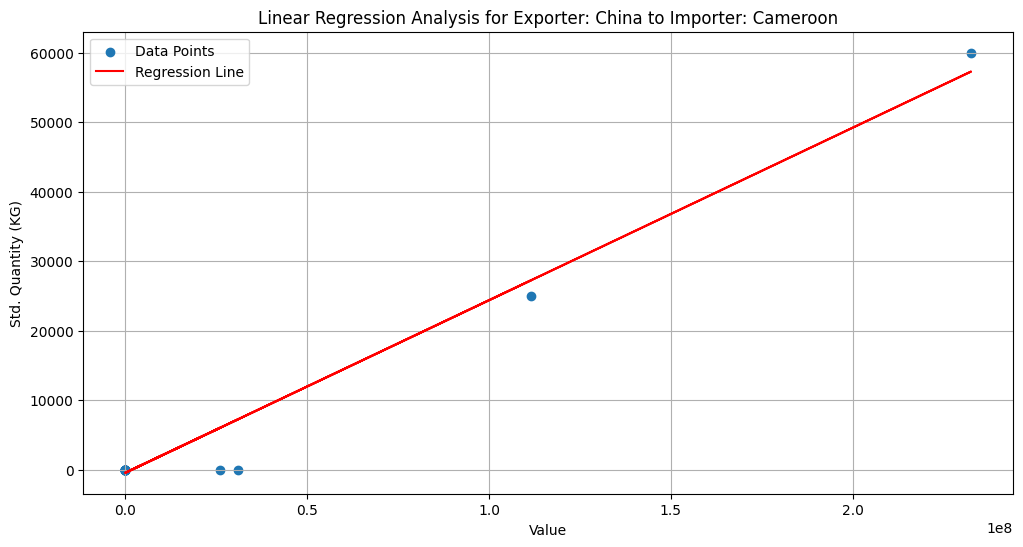

Exporter: China, Importer: India
Pearson Correlation Coefficient: -0.025643583436517695
Spearman Correlation Coefficient: 0.8066730599318923


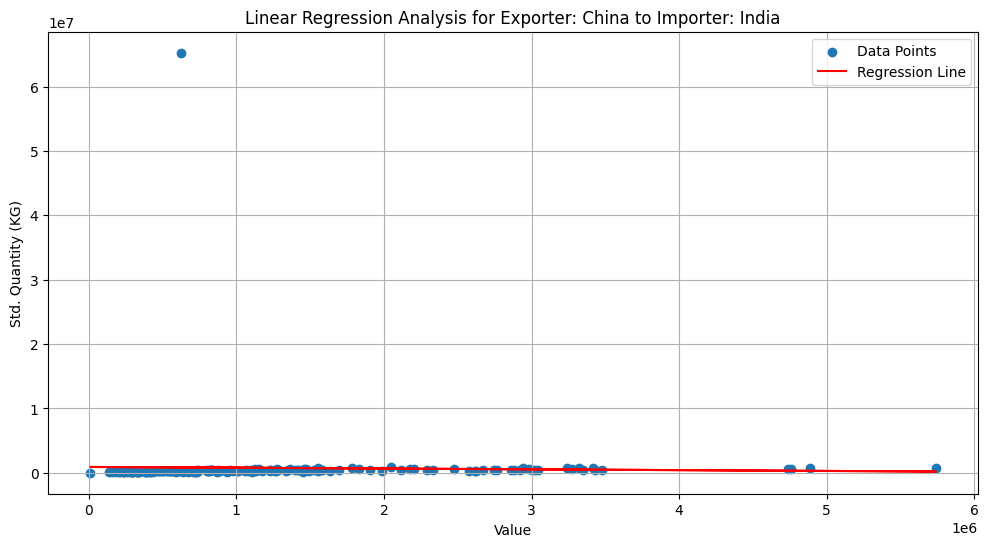

Exporter: China, Importer: Turkey
Pearson Correlation Coefficient: 0.9291661802488466
Spearman Correlation Coefficient: 0.9571195578440094


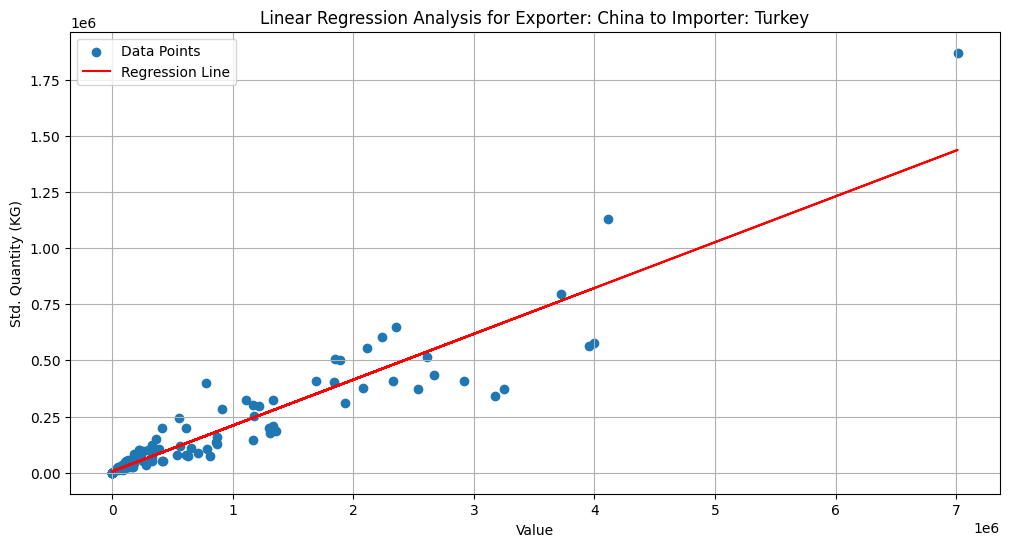

Exporter: China, Importer: Colombia
Pearson Correlation Coefficient: 0.5632031595646024
Spearman Correlation Coefficient: 0.9961876365450953


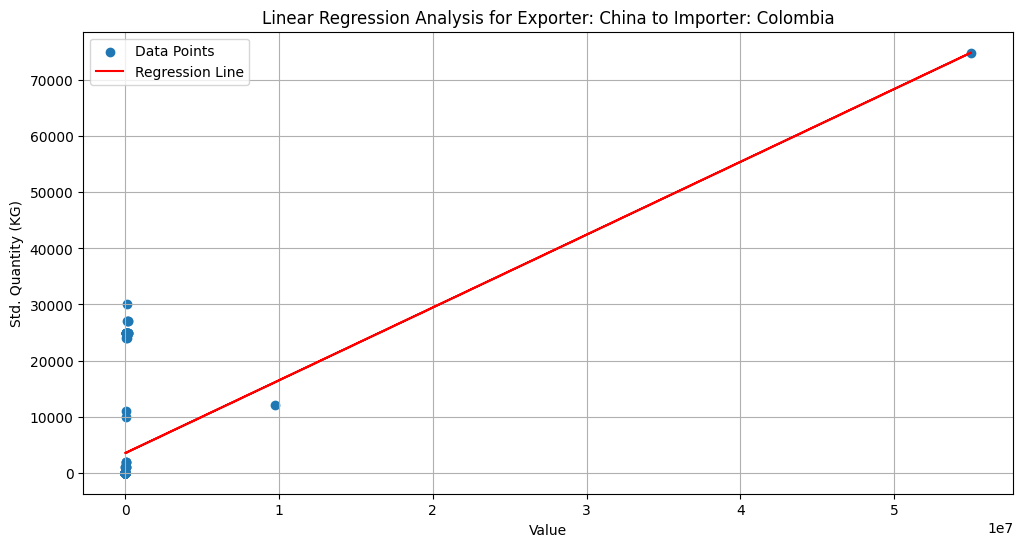

Exporter: China, Importer: Greece
Pearson Correlation Coefficient: 0.8876044965218266
Spearman Correlation Coefficient: 0.991584516970373


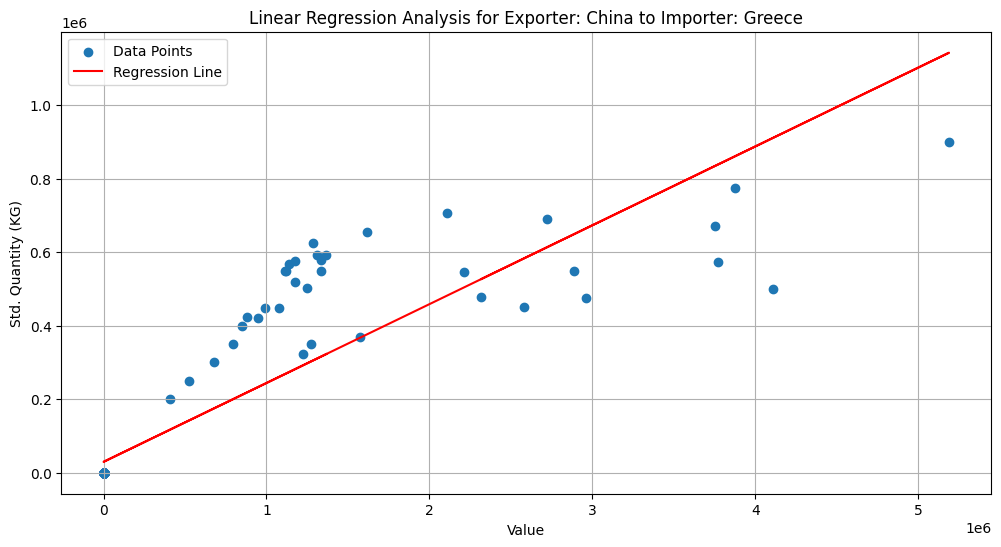

Exporter: China, Importer: Italy
Pearson Correlation Coefficient: 0.8422461836896283
Spearman Correlation Coefficient: 0.992497330423882


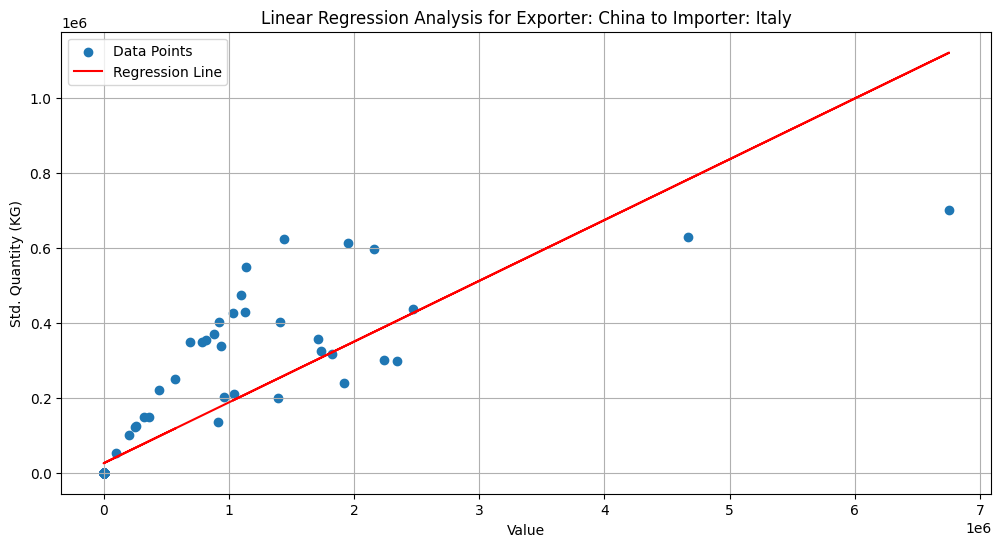

Exporter: China, Importer: Slovenia
Pearson Correlation Coefficient: 0.8416853340510241
Spearman Correlation Coefficient: 0.9932724826357323


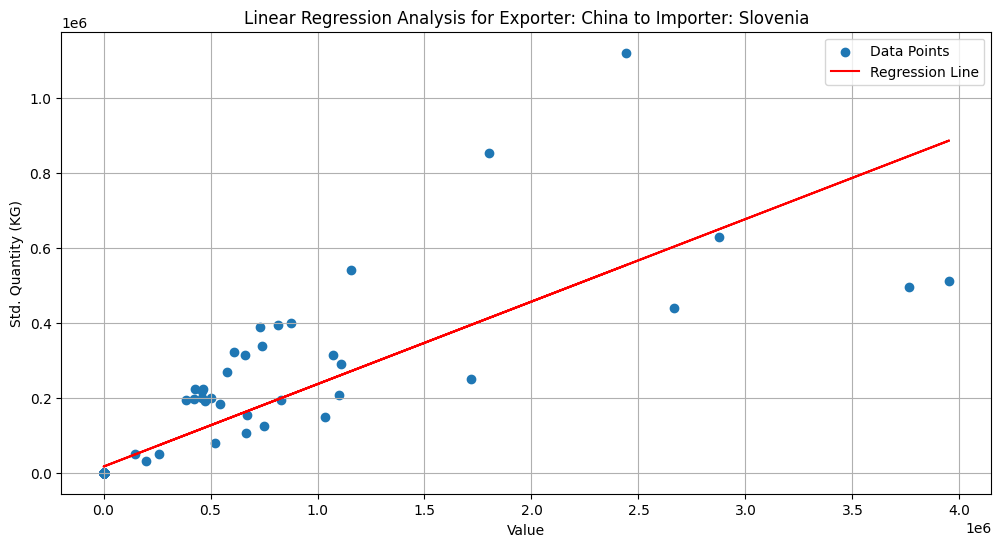

Exporter: China, Importer: Brazil
Pearson Correlation Coefficient: 0.997002835313648
Spearman Correlation Coefficient: 0.9992873416688819


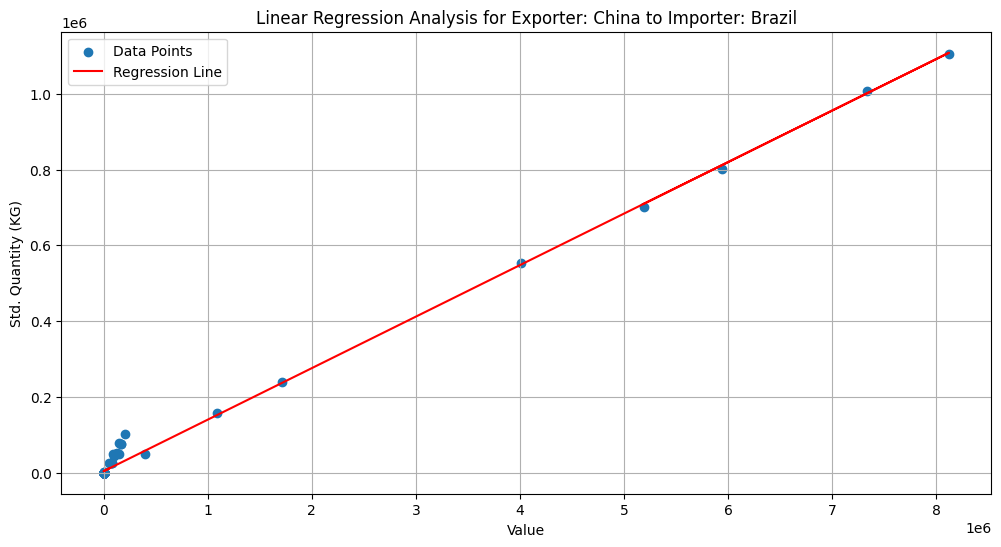

Exporter: China, Importer: Czech Republic
Pearson Correlation Coefficient: 0.9631893366932025
Spearman Correlation Coefficient: 0.9988848414061967


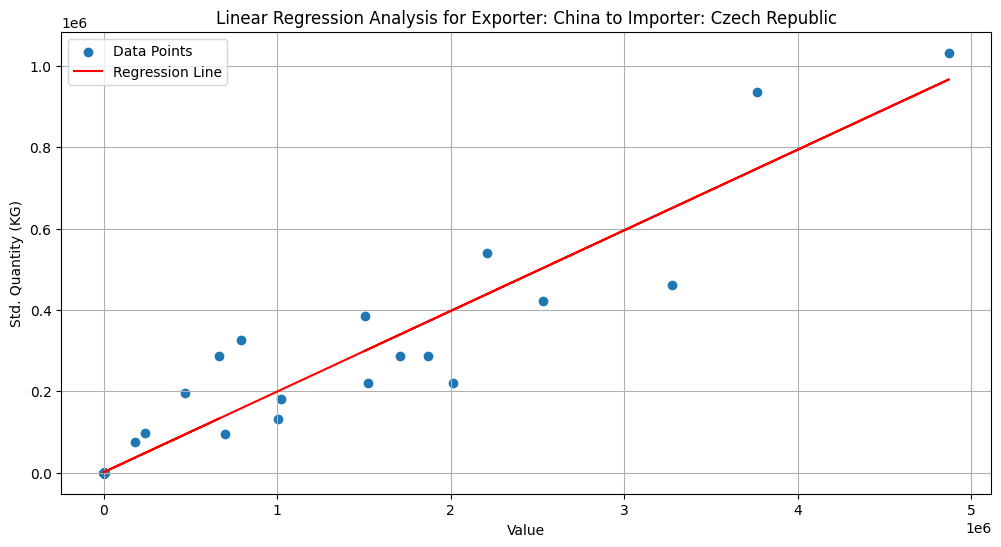

Exporter: Netherlands, Importer: Germany
Pearson Correlation Coefficient: 0.9234429921908472
Spearman Correlation Coefficient: 0.9967453361940435


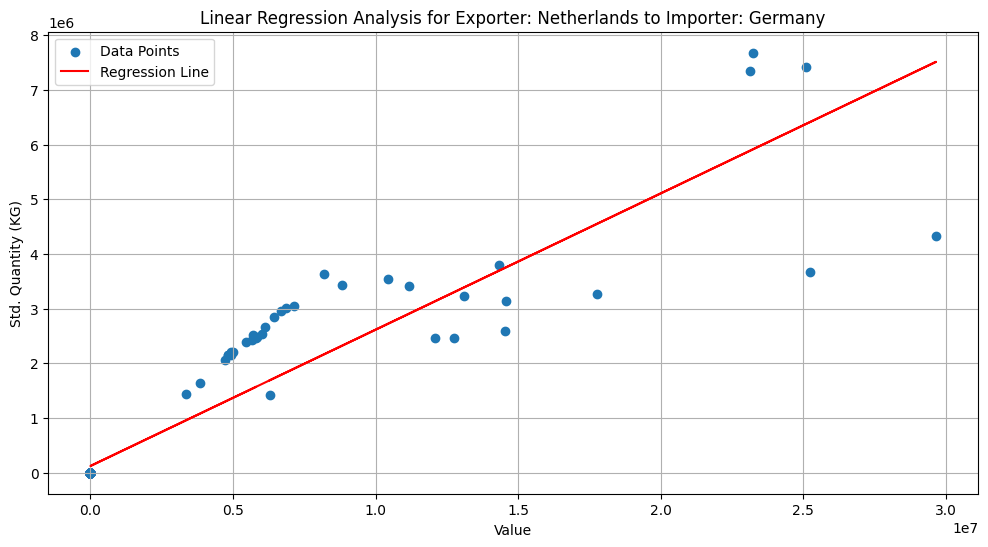

Exporter: Netherlands, Importer: France
Pearson Correlation Coefficient: 0.8782790756240227
Spearman Correlation Coefficient: 0.9932421785034605


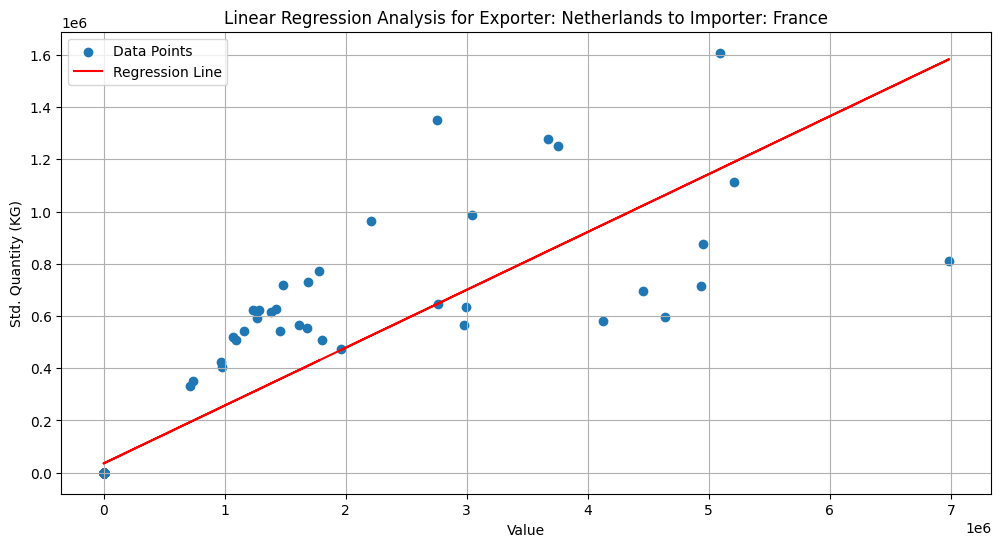

Exporter: Netherlands, Importer: Italy
Pearson Correlation Coefficient: 0.9543813012130096
Spearman Correlation Coefficient: 0.9996787761979224


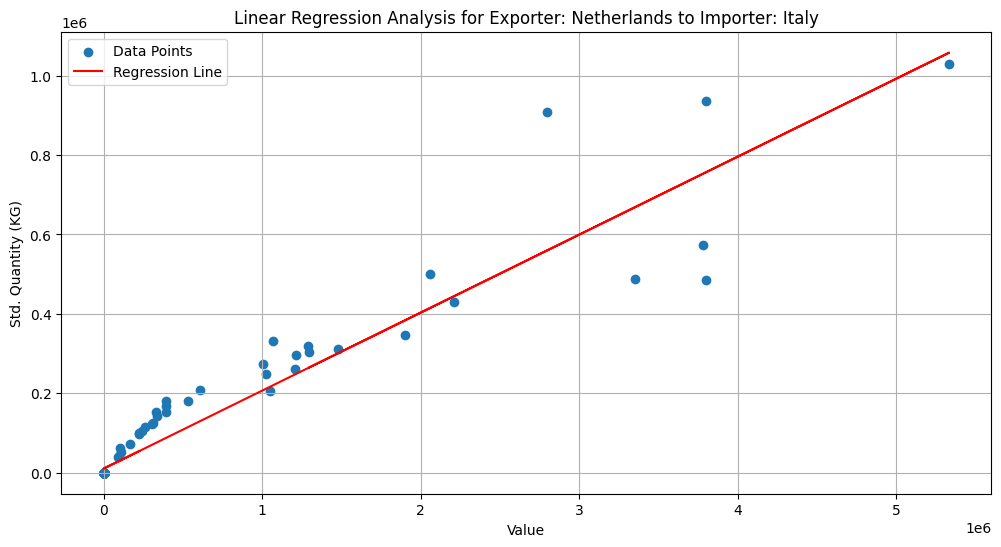

Exporter: Netherlands, Importer: Austria
Pearson Correlation Coefficient: 0.9481109864623305
Spearman Correlation Coefficient: 0.9982362995018


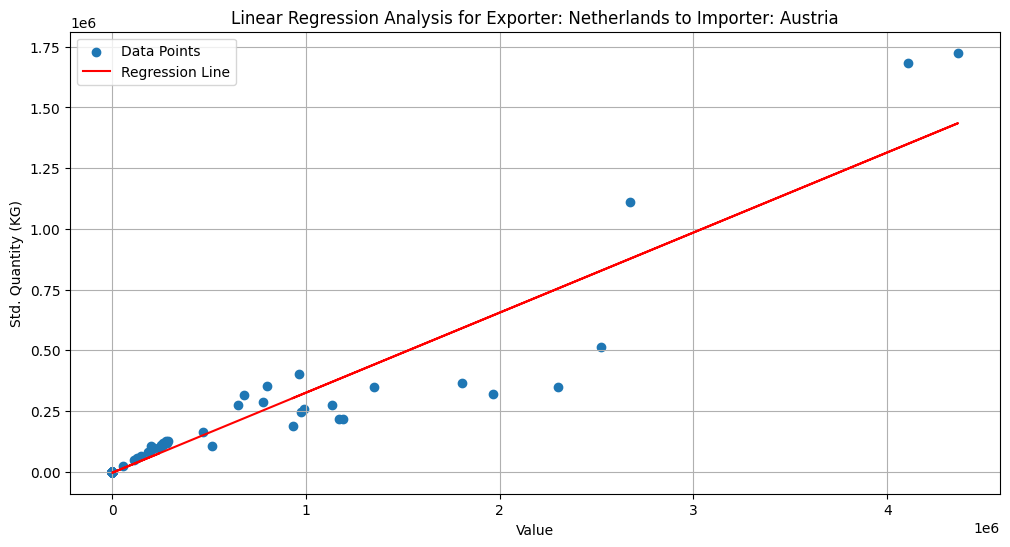

Exporter: Netherlands, Importer: Belgium
Pearson Correlation Coefficient: 0.9835947913707423
Spearman Correlation Coefficient: 0.9982969077663431


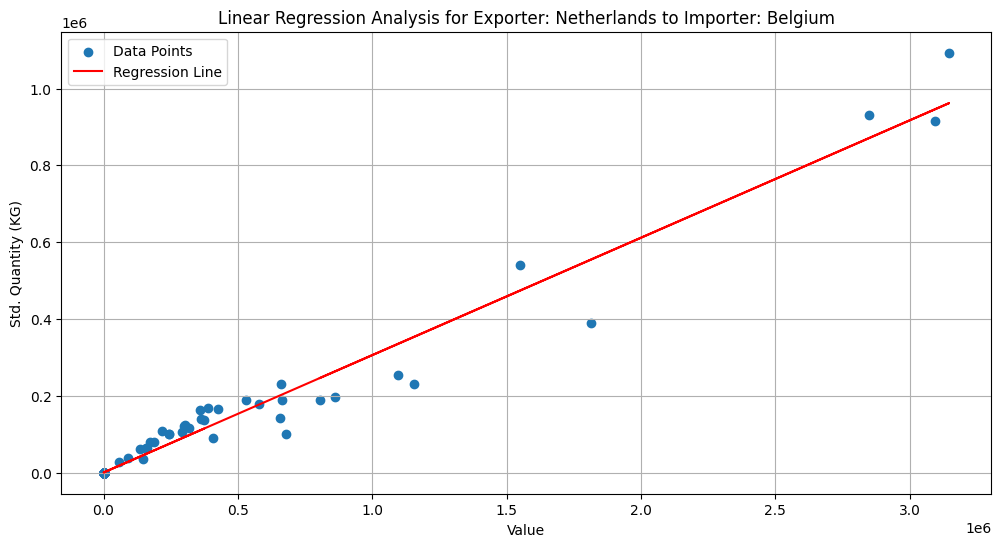

Exporter: Netherlands, Importer: Poland
Pearson Correlation Coefficient: 0.9315651822068135
Spearman Correlation Coefficient: 0.9979453798319939


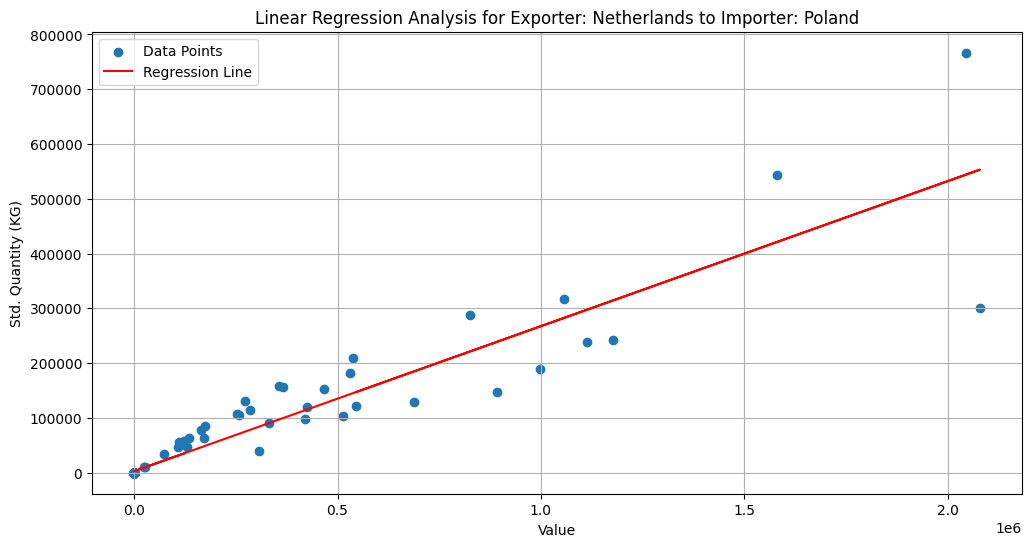

Exporter: Netherlands, Importer: Czech Republic
Pearson Correlation Coefficient: 0.9732091568710308
Spearman Correlation Coefficient: 0.9971695940458442


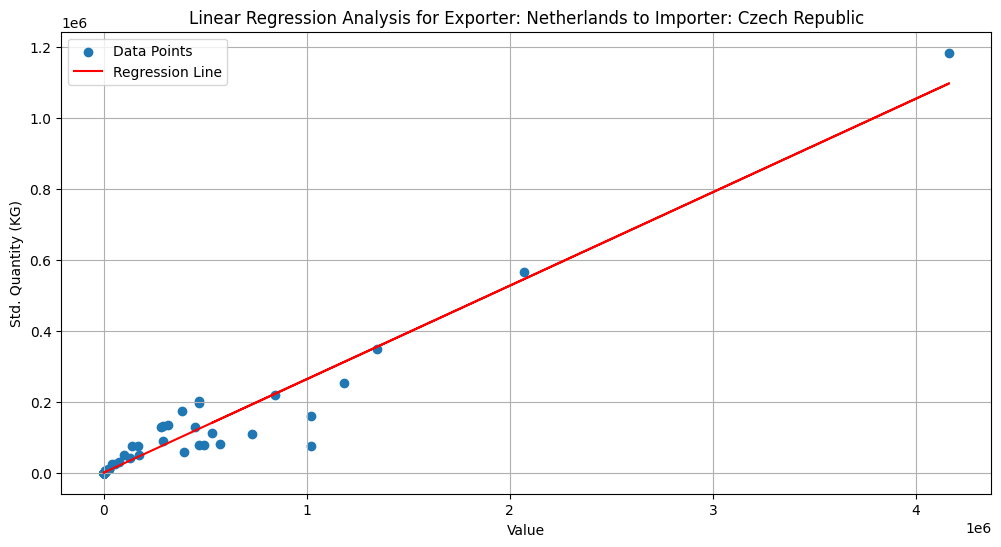

Exporter: Netherlands, Importer: Romania
Pearson Correlation Coefficient: 0.9749162759683746
Spearman Correlation Coefficient: 0.999204515323697


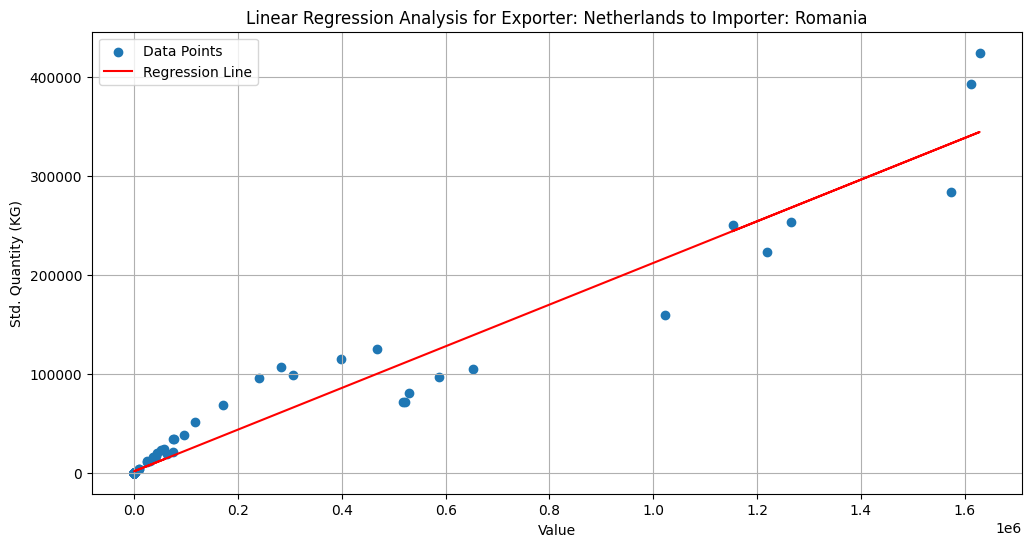

Exporter: Netherlands, Importer: Norway
Pearson Correlation Coefficient: 0.8789716992712361
Spearman Correlation Coefficient: 0.9986953304485336


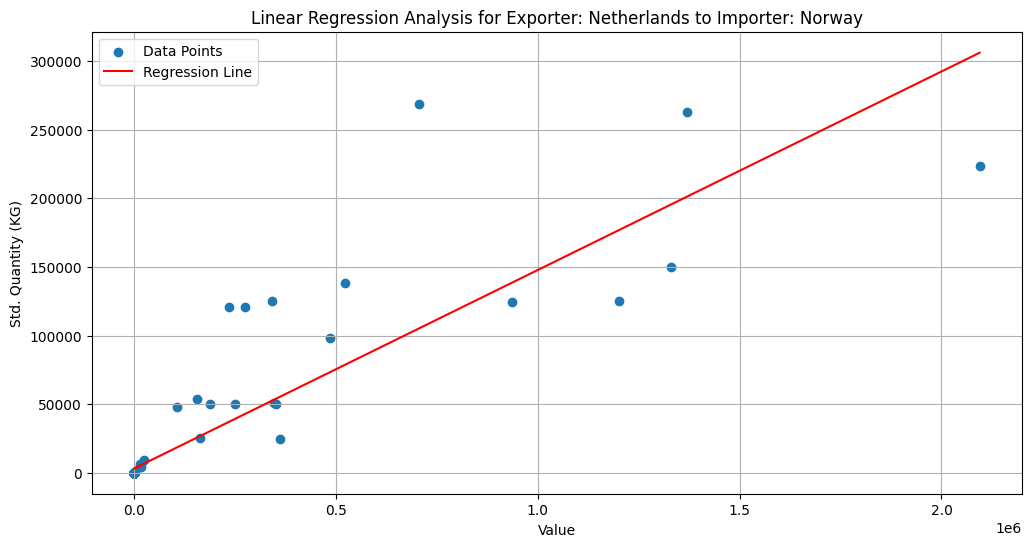

Exporter: Netherlands, Importer: Spain
Pearson Correlation Coefficient: 0.9036960468326038
Spearman Correlation Coefficient: 0.9989817811556785


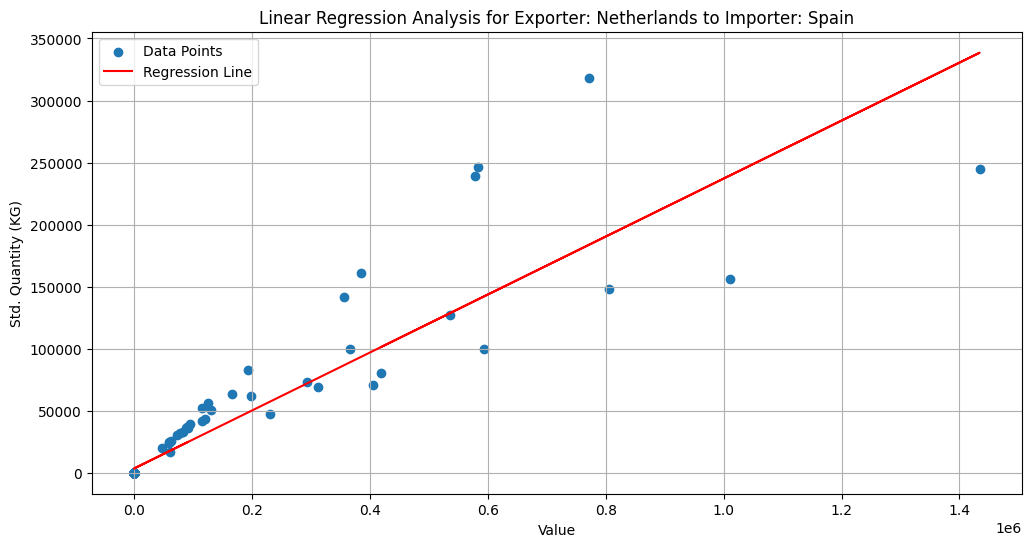

Exporter: Turkey, Importer: United States
Pearson Correlation Coefficient: 0.8383661616121162
Spearman Correlation Coefficient: 0.9355609610378527


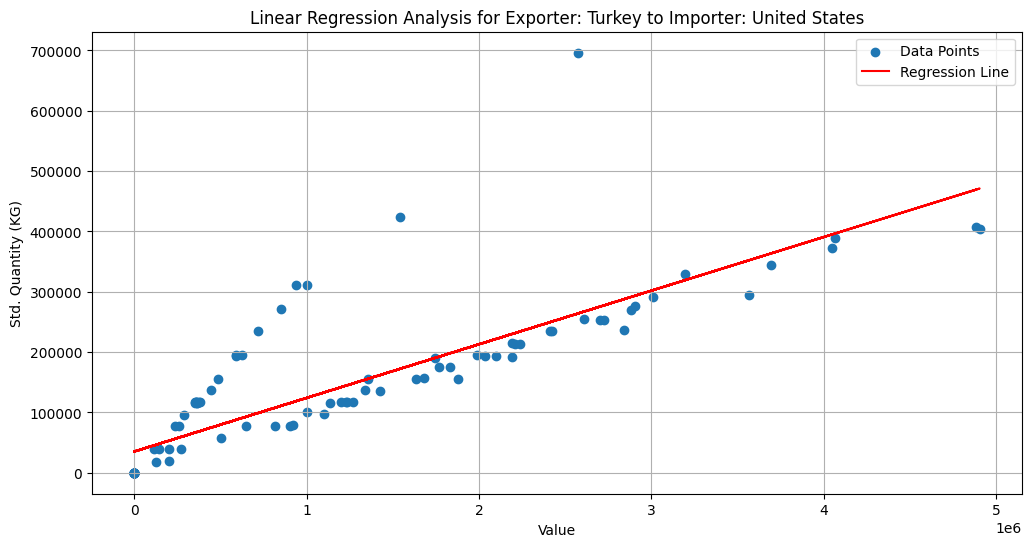

Exporter: Turkey, Importer: Belgium
Pearson Correlation Coefficient: 0.9856086205483044
Spearman Correlation Coefficient: 0.9887952770077585


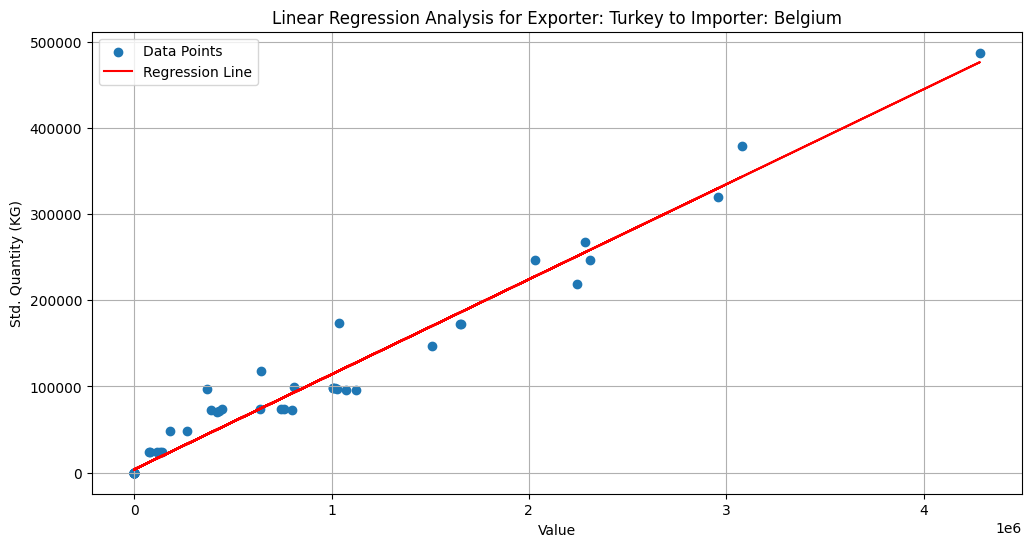

Exporter: Turkey, Importer: Netherlands
Pearson Correlation Coefficient: 0.980190943075211
Spearman Correlation Coefficient: 0.9987070204003446


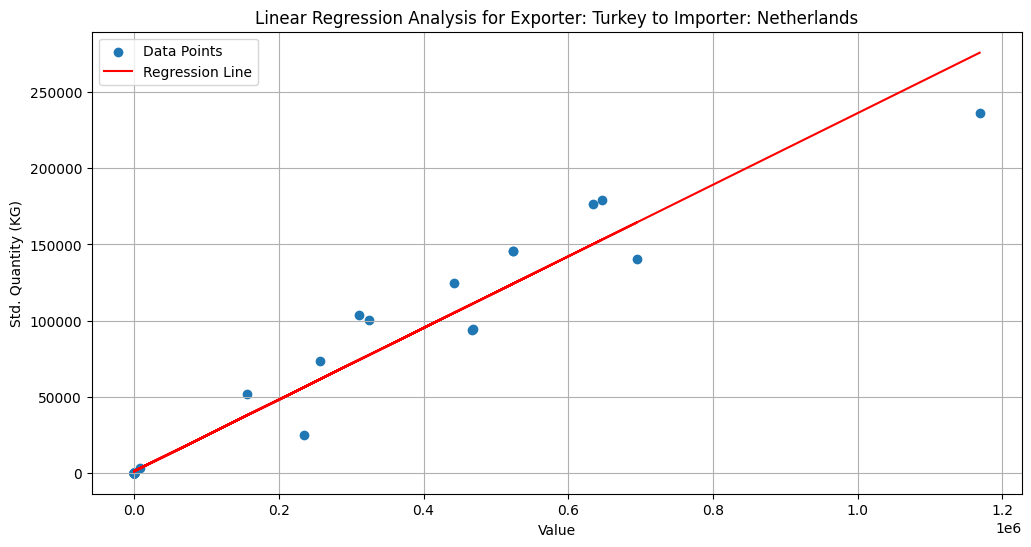

Exporter: Turkey, Importer: Greece
Pearson Correlation Coefficient: 0.9982529993886449
Spearman Correlation Coefficient: 1.0


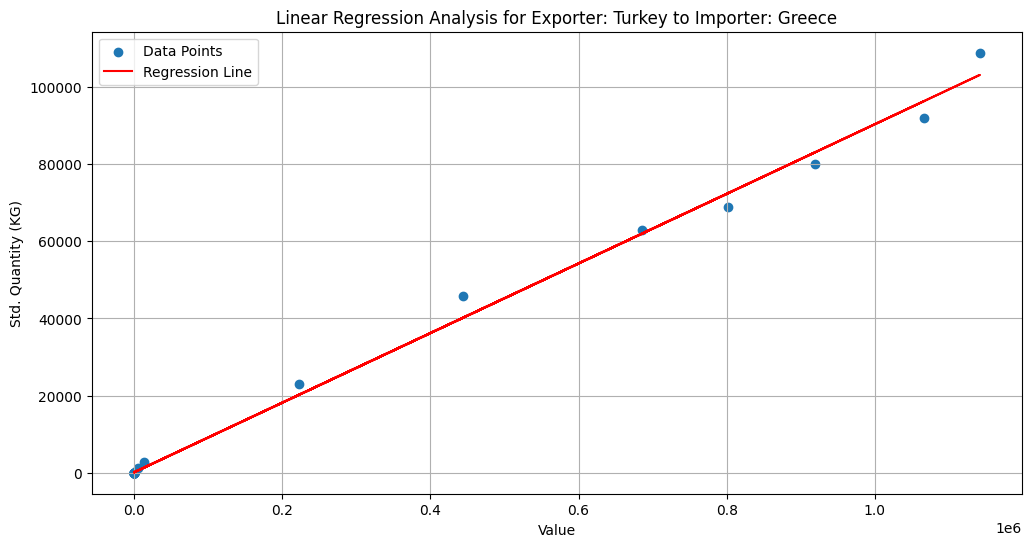

Exporter: Turkey, Importer: Canada
Pearson Correlation Coefficient: 0.9877379643628214
Spearman Correlation Coefficient: 0.9985559566787002


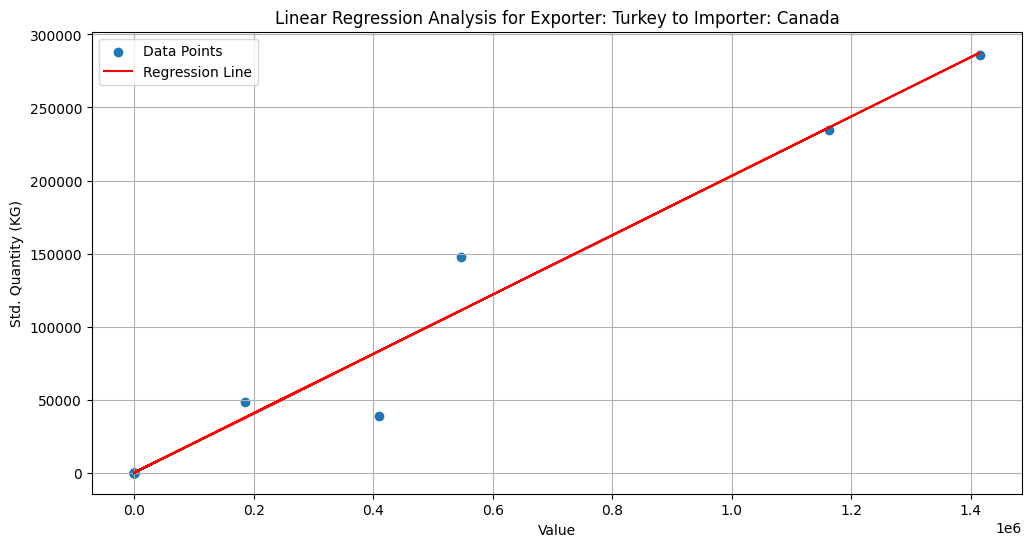

Exporter: Turkey, Importer: Brazil
Pearson Correlation Coefficient: 0.9648315527276337
Spearman Correlation Coefficient: 0.9978486623158461


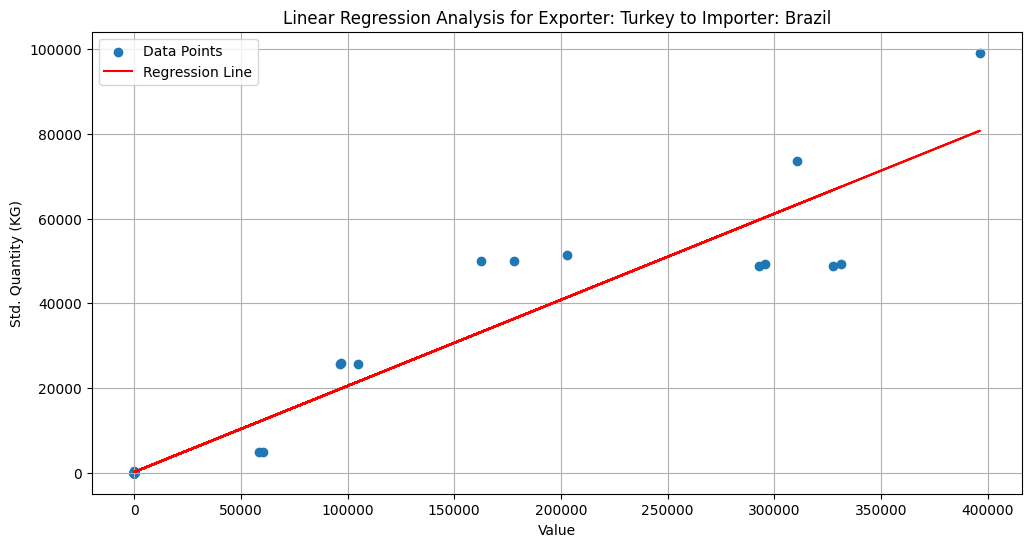

Exporter: Turkey, Importer: Slovenia
Pearson Correlation Coefficient: 0.8369474532891991
Spearman Correlation Coefficient: 0.9847803528190937


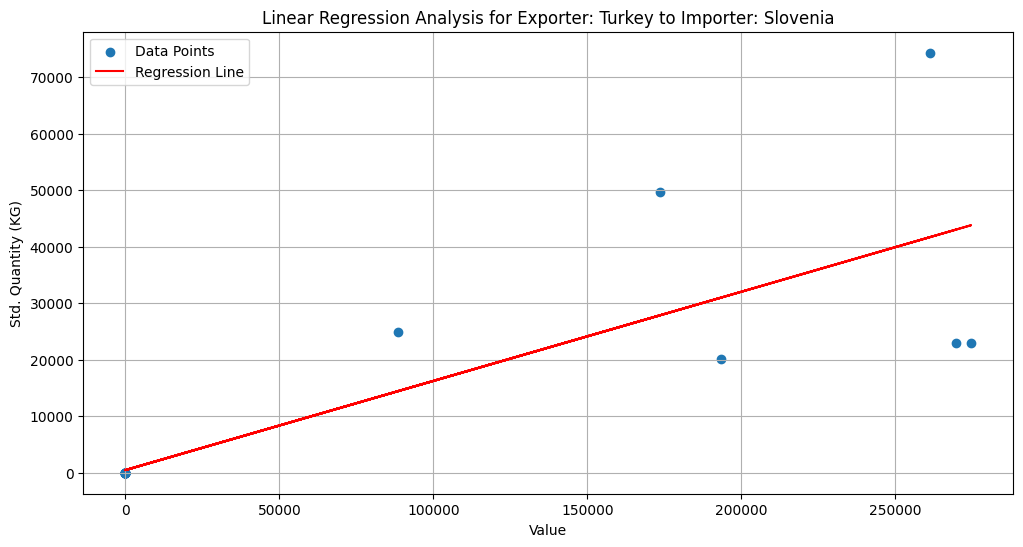

Not enough data for correlation and regression analysis for Exporter: Turkey to Importer: France
Exporter: Turkey, Importer: Spain
Pearson Correlation Coefficient: 0.9999937795889238
Spearman Correlation Coefficient: 0.9999999999999999


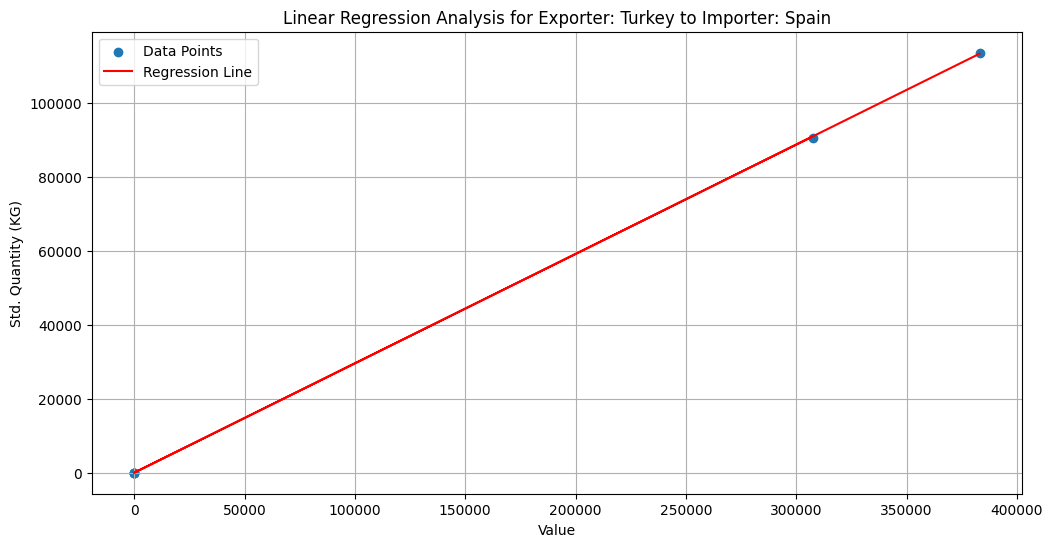

Exporter: Turkey, Importer: Russia
Pearson Correlation Coefficient: 1.0
Spearman Correlation Coefficient: 0.9999999999999999


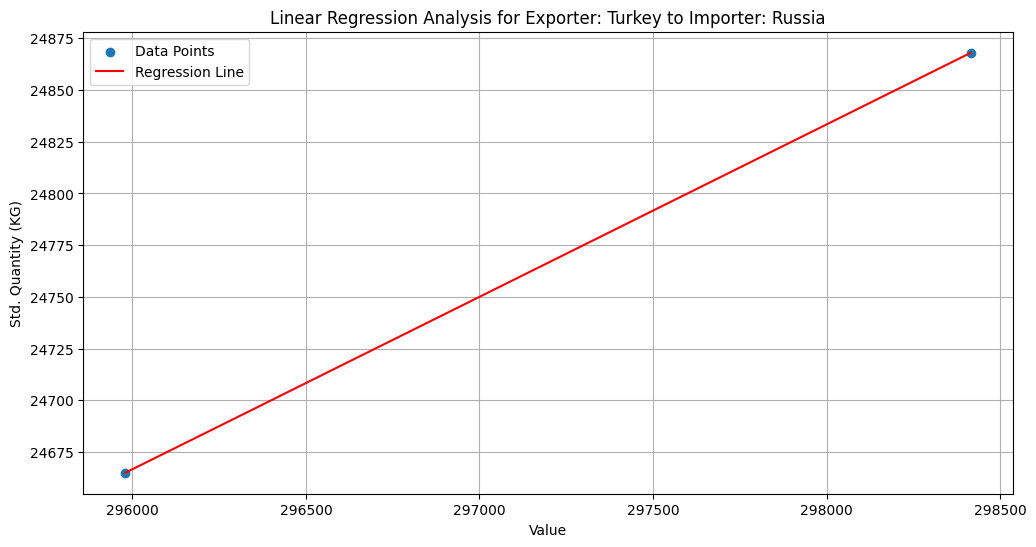

Exporter: Germany, Importer: France
Pearson Correlation Coefficient: 0.8995912824692222
Spearman Correlation Coefficient: 0.9920906214771446


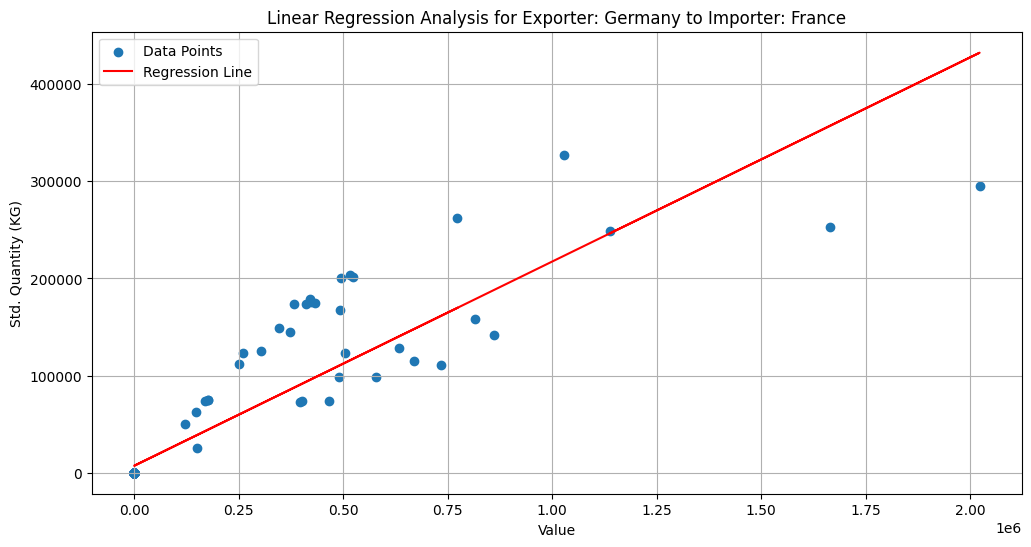

Exporter: Germany, Importer: Spain
Pearson Correlation Coefficient: 0.9227569430902132
Spearman Correlation Coefficient: 0.9965655201609593


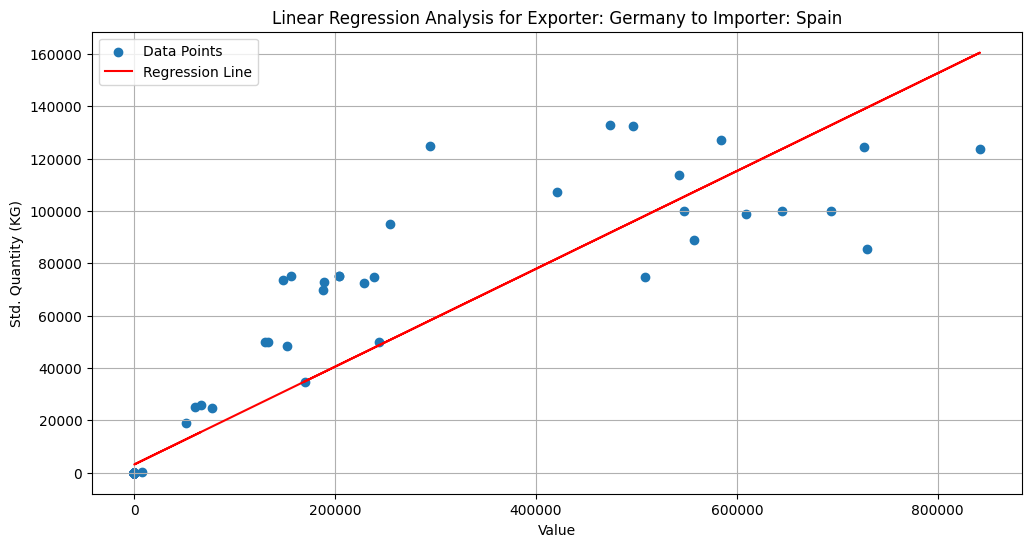

Exporter: Germany, Importer: Belgium
Pearson Correlation Coefficient: 0.9795099087386845
Spearman Correlation Coefficient: 0.998290841760433


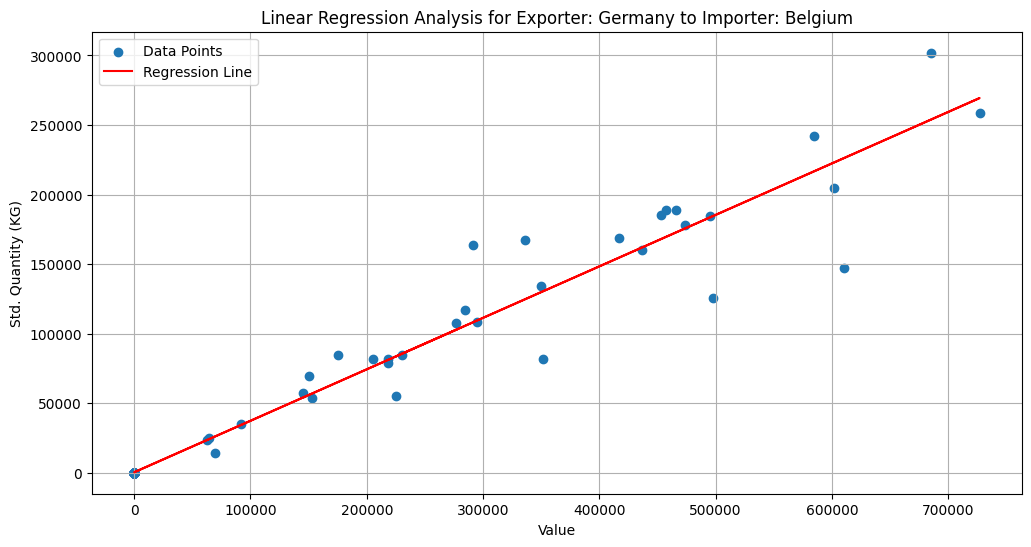

Exporter: Germany, Importer: Hungary
Pearson Correlation Coefficient: 0.8556184912283633
Spearman Correlation Coefficient: 0.9967182007652347


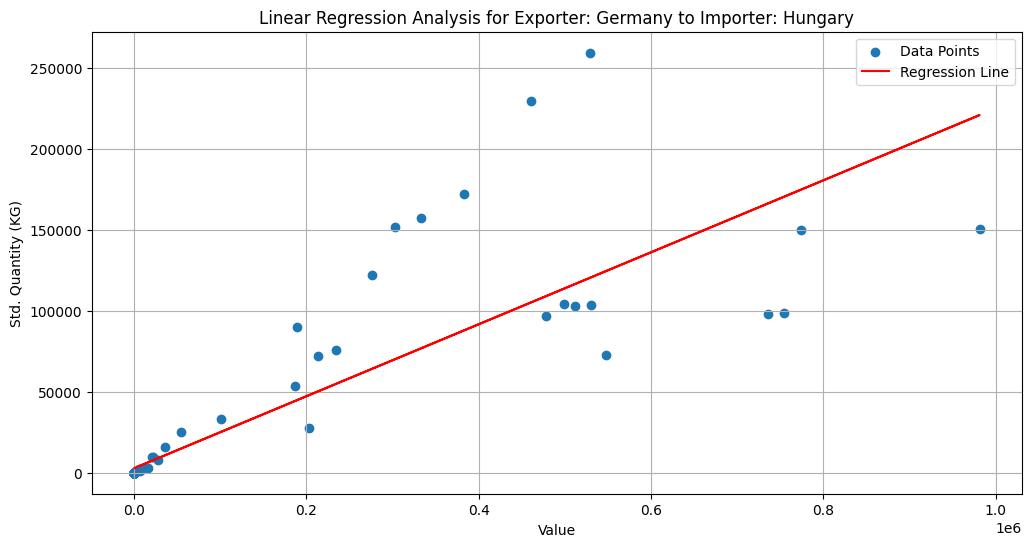

Exporter: Germany, Importer: Italy
Pearson Correlation Coefficient: 0.7882029350133493
Spearman Correlation Coefficient: 0.995806819711596


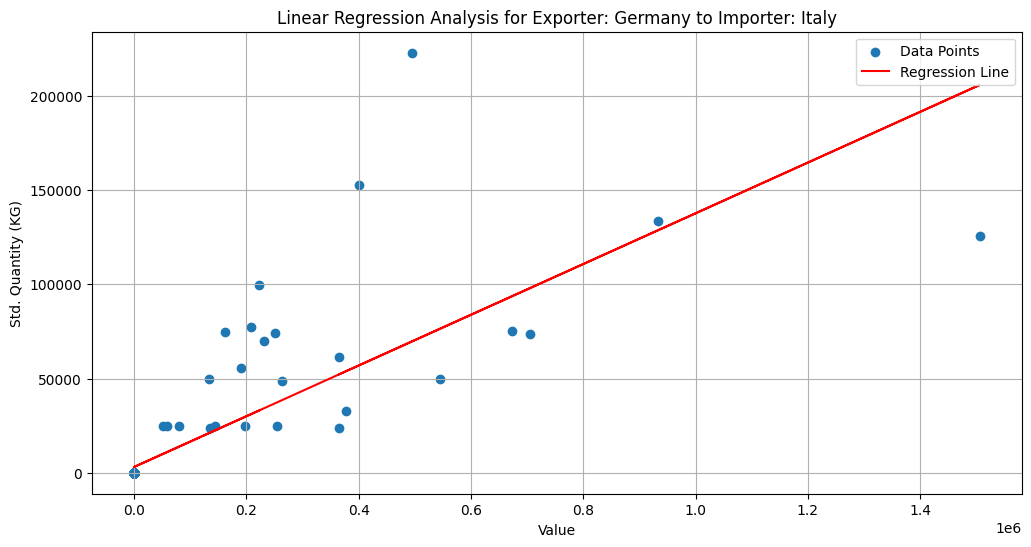

Exporter: Germany, Importer: Netherlands
Pearson Correlation Coefficient: 0.9624290384697092
Spearman Correlation Coefficient: 0.9989459991327841


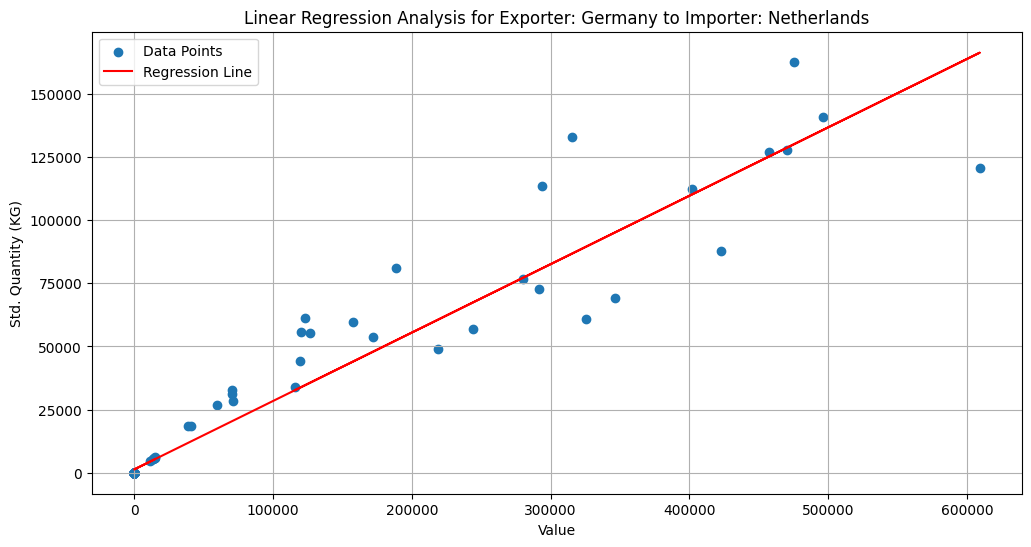

Exporter: Germany, Importer: Czech Republic
Pearson Correlation Coefficient: 0.9231508111822894
Spearman Correlation Coefficient: 0.9974391996393772


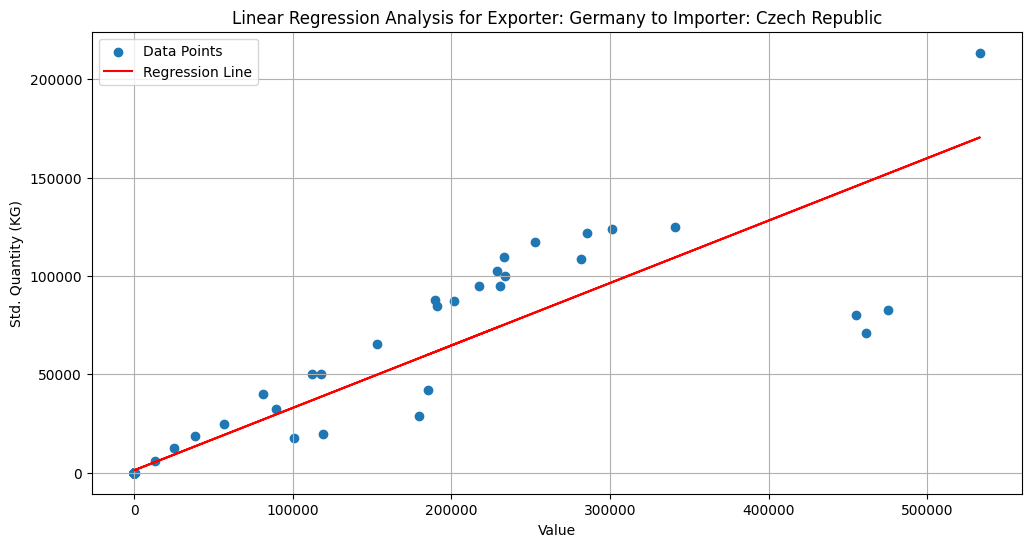

Exporter: Germany, Importer: Poland
Pearson Correlation Coefficient: 0.8451800595687128
Spearman Correlation Coefficient: 0.9983407270187068


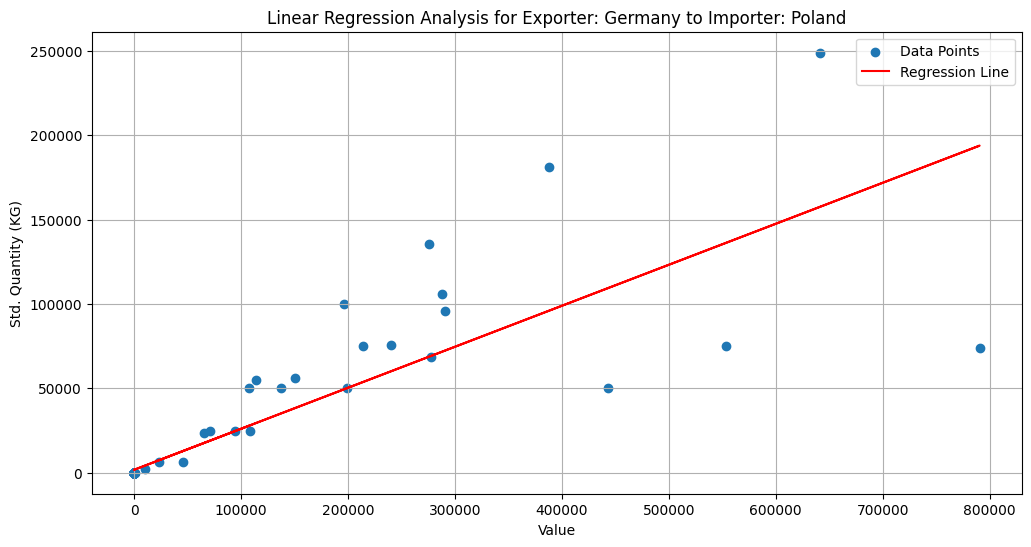

Exporter: Germany, Importer: Romania
Pearson Correlation Coefficient: 0.9838170661060884
Spearman Correlation Coefficient: 0.9998798991152565


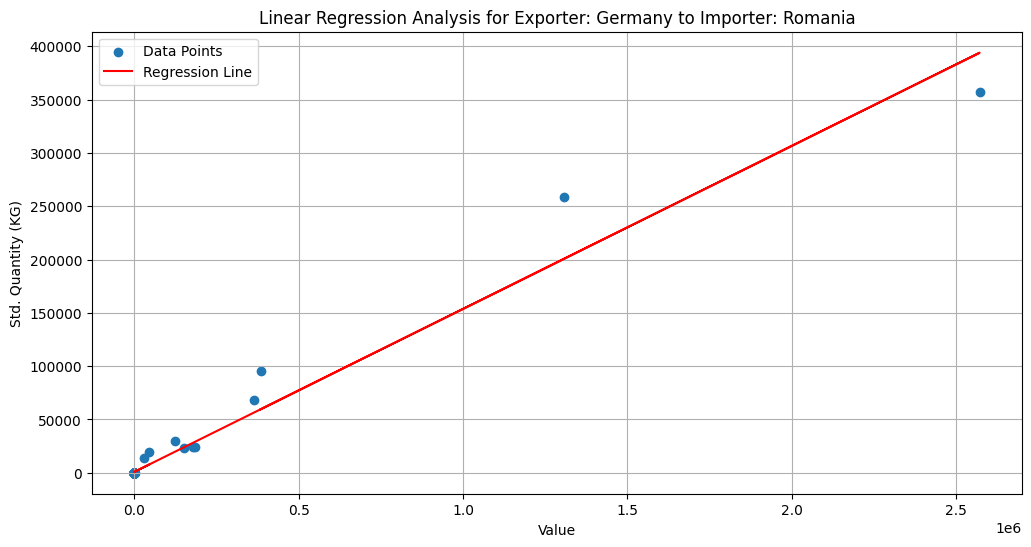

Exporter: Germany, Importer: Sweden
Pearson Correlation Coefficient: 0.819499950958341
Spearman Correlation Coefficient: 0.9936185561289607


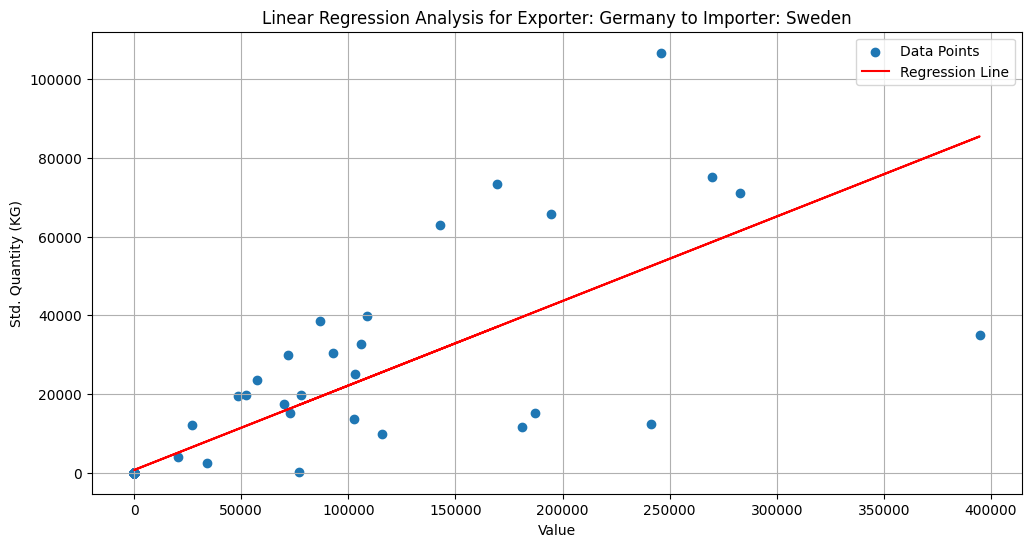

Exporter: Belgium, Importer: Germany
Pearson Correlation Coefficient: 0.8660674398848401
Spearman Correlation Coefficient: 0.996121071069251


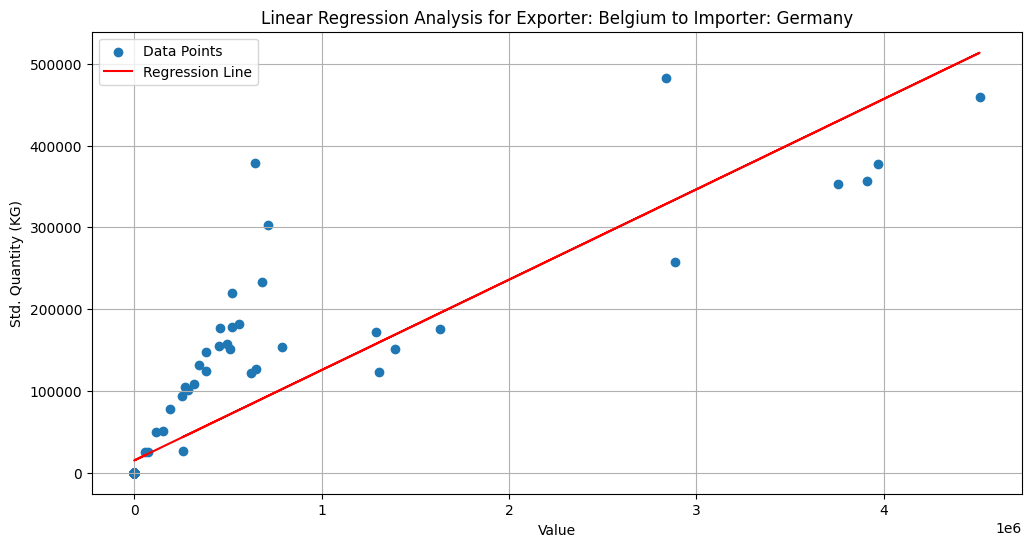

Exporter: Belgium, Importer: France
Pearson Correlation Coefficient: 0.8337496527235897
Spearman Correlation Coefficient: 0.9935997138146638


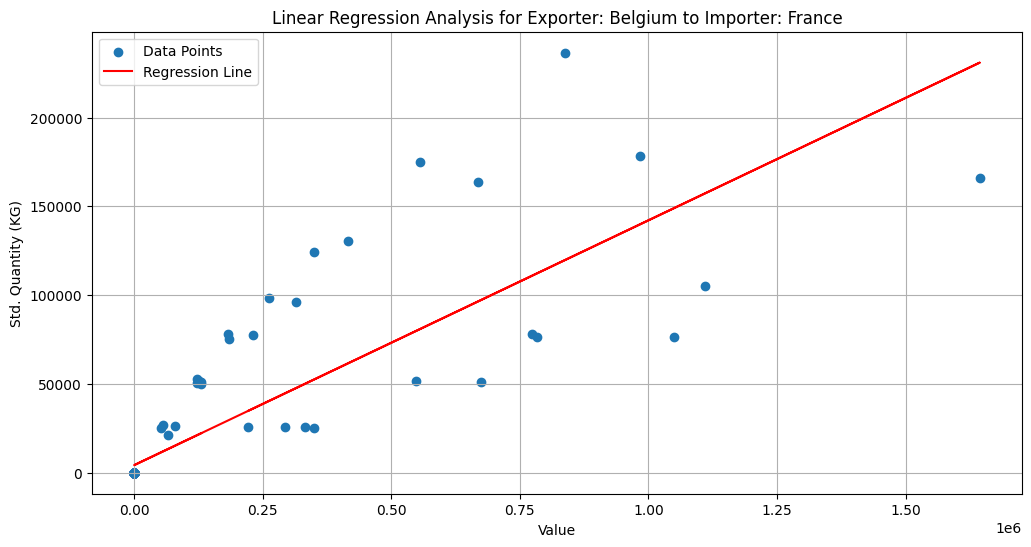

Exporter: Belgium, Importer: Czech Republic
Pearson Correlation Coefficient: 0.8098971384485613
Spearman Correlation Coefficient: 0.997450876261285


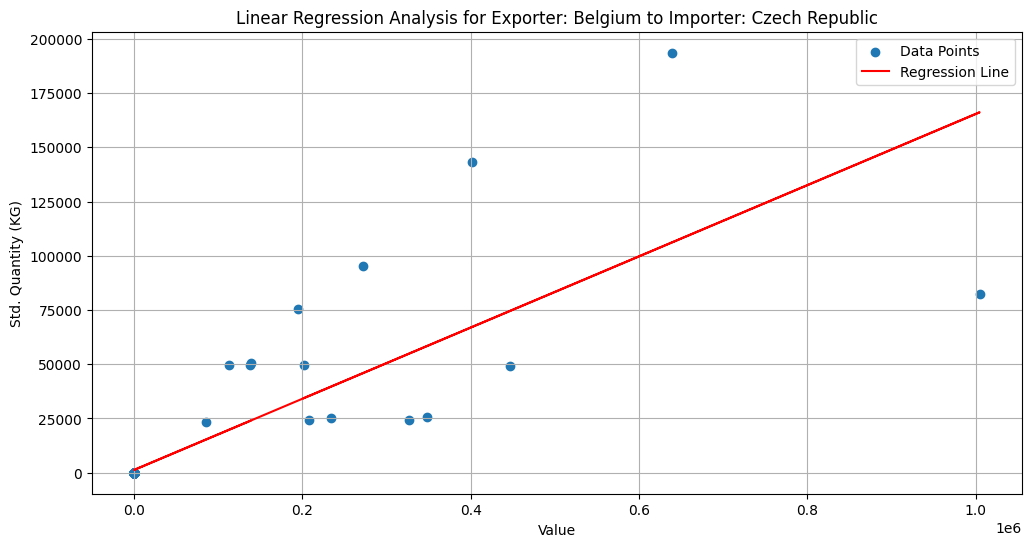

Exporter: Belgium, Importer: United States
Pearson Correlation Coefficient: 0.9999123674500995
Spearman Correlation Coefficient: 1.0


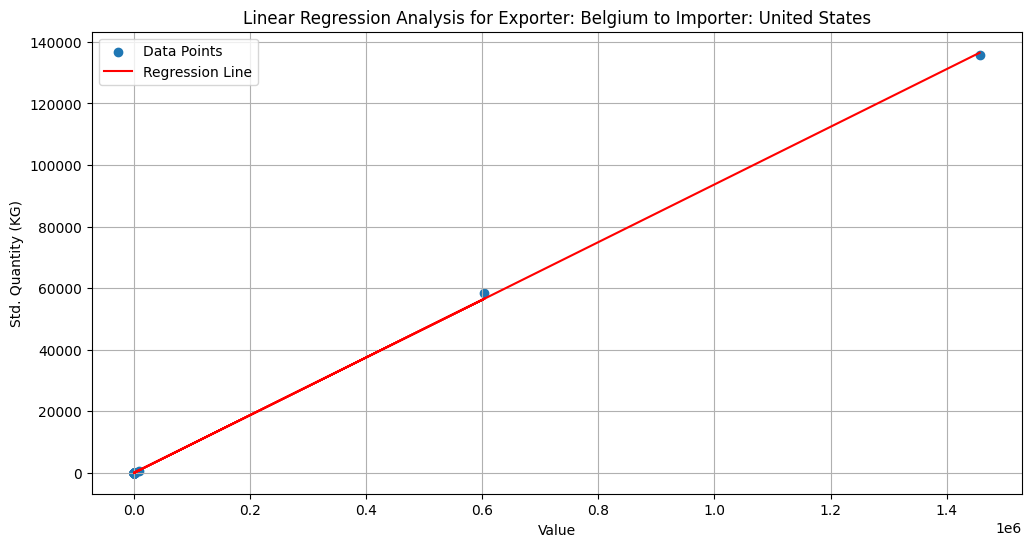

Exporter: Belgium, Importer: Switzerland
Pearson Correlation Coefficient: 0.840341415708084
Spearman Correlation Coefficient: 0.9902467010900745


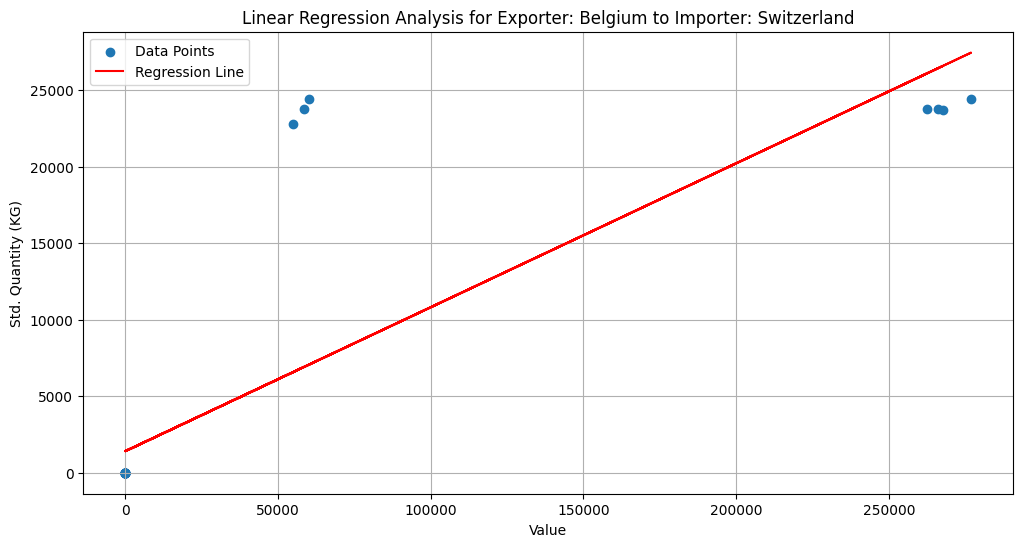

Exporter: Belgium, Importer: Hungary
Pearson Correlation Coefficient: 0.9644281188802253
Spearman Correlation Coefficient: 0.9996310473642946


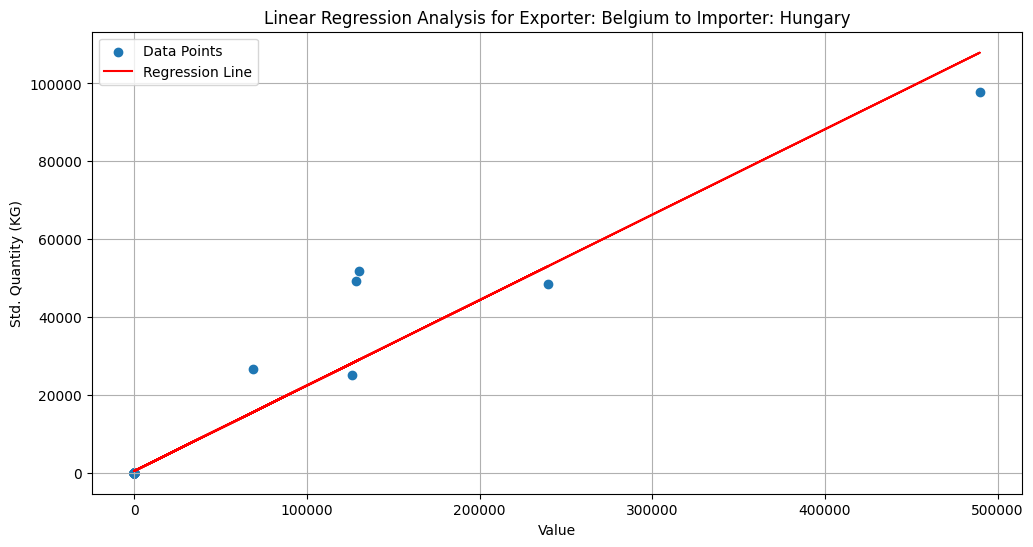

Exporter: Belgium, Importer: Austria
Pearson Correlation Coefficient: 0.9999800158218037
Spearman Correlation Coefficient: 0.9999999999999999


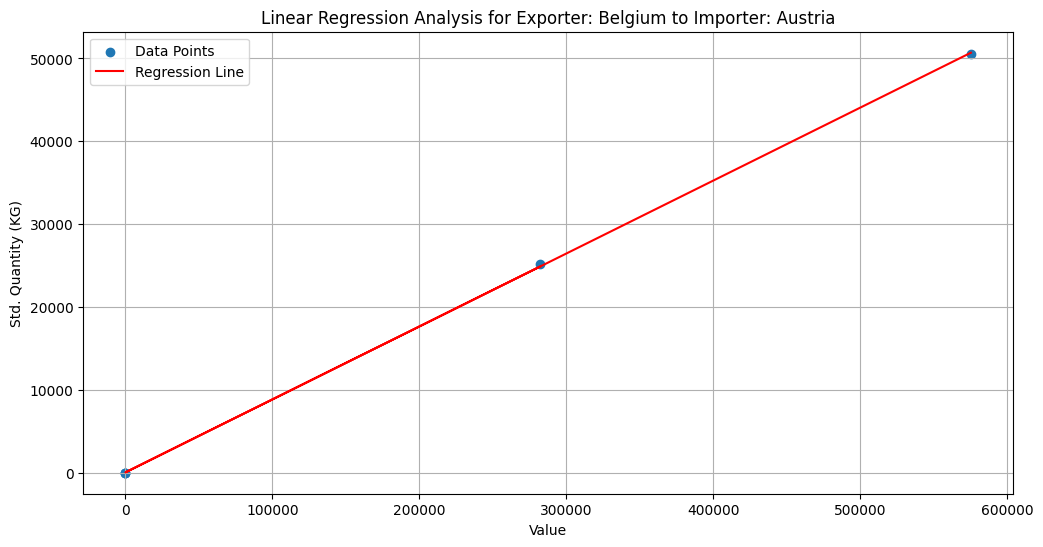

Exporter: Belgium, Importer: Netherlands
Pearson Correlation Coefficient: 0.9103553272436931
Spearman Correlation Coefficient: 0.999989041936509


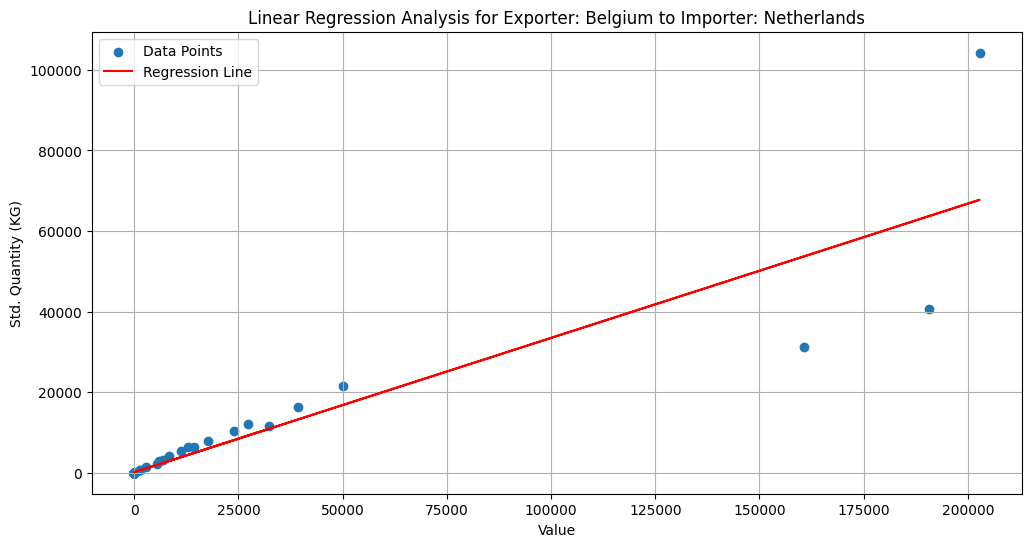

Exporter: Belgium, Importer: Italy
Pearson Correlation Coefficient: 0.9999999999567794
Spearman Correlation Coefficient: 0.9999999999999999


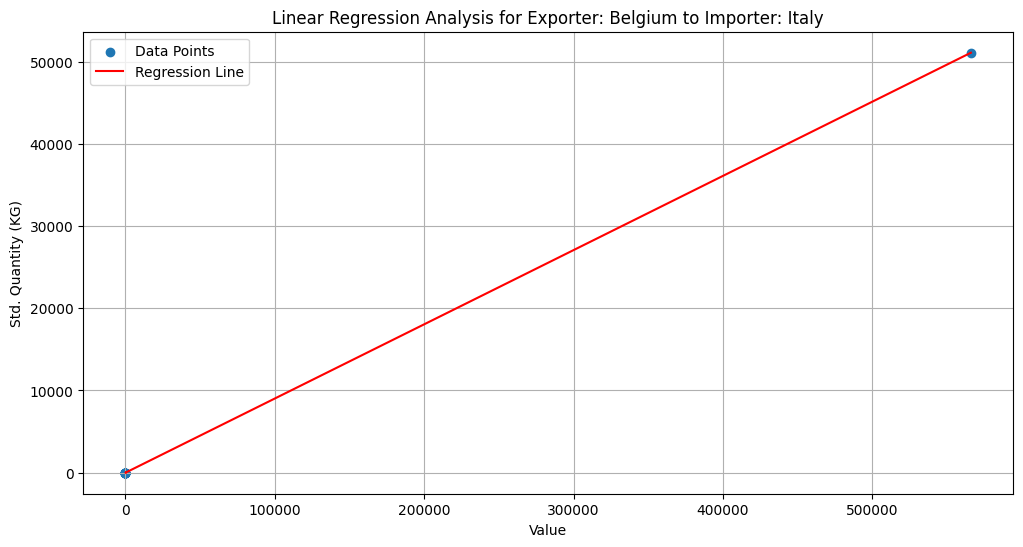

Not enough data for correlation and regression analysis for Exporter: Belgium to Importer: United Kingdom


In [ ]:
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr

# Assuming combined_df is your DataFrame
# and top_exporters and top_importers_by_exporter are already defined
TIME_METRIC = '7D'

for exporter, importers in top_importers_by_exporter.items():
    for importer in importers:
        # Filter data for specific exporter-importer pair
        export_import_data = combined_df[(combined_df['Country of Origin'] == exporter) & (combined_df['Country of Destination'] == importer)]

        # Resample and sum
        weekly_data = export_import_data[['Value', 'Std. Quantity (KG)']].resample(TIME_METRIC).sum()

        # Ensure there are enough data points
        if weekly_data.shape[0] > 1:
            # Correlation Analysis
            pearson_corr, _ = pearsonr(weekly_data['Value'], weekly_data['Std. Quantity (KG)'])
            spearman_corr, _ = spearmanr(weekly_data['Value'], weekly_data['Std. Quantity (KG)'])
            print(f"Exporter: {exporter}, Importer: {importer}")
            print(f"Pearson Correlation Coefficient: {pearson_corr}")
            print(f"Spearman Correlation Coefficient: {spearman_corr}")

            # Regression Analysis
            X = weekly_data['Value']
            y = weekly_data['Std. Quantity (KG)']
            X = sm.add_constant(X)  # Add a constant term to the predictor
            model = sm.OLS(y, X).fit()
            predictions = model.predict(X)

            # Plotting the linear regression
            plt.figure(figsize=(12, 6))
            plt.scatter(weekly_data['Value'], weekly_data['Std. Quantity (KG)'], label='Data Points')
            plt.plot(weekly_data['Value'], predictions, color='red', label='Regression Line')
            plt.xlabel('Value')
            plt.ylabel('Std. Quantity (KG)')
            plt.title(f'Linear Regression Analysis for Exporter: {exporter} to Importer: {importer}')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"Not enough data for correlation and regression analysis for Exporter: {exporter} to Importer: {importer}")


Granger Causality Test Results:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.9273 , p=0.0011  , df_denom=32, df_num=1
ssr based chi2 test:   chi2=14.1393 , p=0.0002  , df=1
likelihood ratio test: chi2=11.8759 , p=0.0006  , df=1
parameter F test:         F=12.9273 , p=0.0011  , df_denom=32, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.6264  , p=0.0043  , df_denom=29, df_num=2
ssr based chi2 test:   chi2=15.5377 , p=0.0004  , df=2
likelihood ratio test: chi2=12.7967 , p=0.0017  , df=2
parameter F test:         F=6.6264  , p=0.0043  , df_denom=29, df_num=2


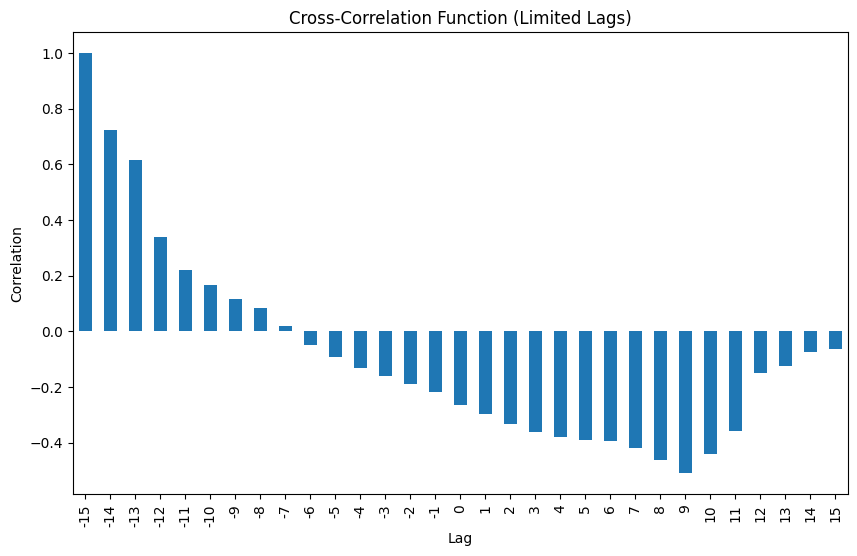

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

# Assuming weekly_export and weekly_import are already calculated as before

# Granger Causality Test
max_lag = 2  # Maximum number of lags to test for - can be adjusted
print("Granger Causality Test Results:")
granger_test_result = grangercausalitytests(combined_weekly, max_lag, verbose=True)

# Cross-Correlation Analysis
max_lags = 15  # Maximum lags in each direction
ccf = pd.Series(sm.tsa.stattools.ccf(combined_weekly['Export_Value'], combined_weekly['Import_Value'], unbiased=True))
ccf = ccf[:max_lags * 2 + 1]  # Keep only the first 2*max_lags+1 lags

# Plotting the Cross-Correlation Function
plt.figure(figsize=(10, 6))
ccf.plot(kind='bar')
plt.title('Cross-Correlation Function (Limited Lags)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.xticks(ticks=range(2 * max_lags + 1), labels=[f"{i-max_lags}" for i in range(2 * max_lags + 1)])
plt.show()
